<img alt="PyMC logo" src="https://raw.githubusercontent.com/pymc-devs/pymc/main/docs/logos/PyMC.jpg" width=700>

I first started working with probabilistic programming about ten years ago (in late 2012 or early 2013) using [PyMC2](https://github.com/pymc-devs/pymc2https://github.com/pymc-devs/pymc2).  At the time I was preparing to leave a [PhD program in pure math](https://math.illinois.edu/academics/graduate-program-mathematics) for a data science career in [industry](https://kibocommerce.com/personalization-software/?utm_campaign=monetate_redirect).  I found that the Bayesian approach to statistics and machine learning appealed to my mathematical sensibilities. I soon found [PyMC3](https://github.com/pymc-devs/pymc/tree/v3) and loved how it provided a fast path to translate the mathematical models I had in my head into executable code.  A lot has changed in the past ten years; I have grown professionally and technically, the theory behind applied Bayesian inference (in particular adaptive Hamiltonian Monte Carlo algorithms) has blossomed, and PyMC and its related libraries have matured.  This post presents an introduction to what I think of as a _modern_ probabilistic programming with PyMC from a perspective that my experience over the last decade has shaped.  It is modern in two respects:

1. It features modern Bayesian inference algorithms and best practices, preferring adaptive Hamiltonian Monte Carlo samplers over Metropolis-Hastings-style ones.  It introduces recently developed/enhanced diagnostic tools to diagnose the convergence (or not) of these agorithms.
2. It features the cutting-edge [beta version of PyMC v4](https://docs.pymc.io/en/latest/) and relies heavily on Aesara and ArviZ, both of which did not exist ten years ago.

This post is an extended version of an introductory [talk](https://pymc-data-umbrella.xyz/en/latest/webinars/probabilistic_programming_with_pymc/index.html#probprog-pymc) I gave in January 2022 for the [Data Umbrella and PyMC sprint](https://pymc-data-umbrella.xyz/) meant to introduce potential new contributors to PyMC.  You can find a video of this talk [on YouTube](https://www.youtube.com/watch?v=Qu6-_AnRCs8).

## Table of contents

* [Probabilistic programming from three perspectives](#Probabilistic-programming-from-three-perspectives)
    * [Theoretical](#Theoretical)
    * [Statistical](#Statistical)
    * [Computational](#Computational)
        * [A Monte Carlo approximation of $\pi$](#A-Monte-Carlo-approximation-of-pi)
* [Probabilitic programming with PyMC](#Probabilistic-programming-with-PyMC)
    * [The Monty Hall problem](#The-Monty-Hall-problem)
    * [PyMC distributions](#PyMC-distributions)
    * [Aesara](#Aesara)
        * [Automating calculus](#Automating-calculus)
        * [Hamiltonian Monte Carlo, the curse of dimensionality, and differential geometry](#Hamiltonian-Monte-Carlo,-the-curse-of-dimensionality,-and-differential-geometry)
    * [Robust regression](#Robust-regression)
        * [Anscombe's quartet](#Anscombe's-quartet)
        * [Ordinary least squares](#Ordinary-least-squares)
        * [ArviZ](#ArviZ)
        * [Xarray](#Xarray)
        * [Bayesian Ridge Regression](#Bayesian-Ridge-Regression)
        * [Robust regression](#Robust-regression-2)
* [A Bayesian analysis of Lego set prices](#A-Bayesian-analysis-of-Lego-set-prices)
    * [Exploratory data analysis](#Exploratory-data-analysis)
    * [Price model](#Price-model)
        * [Why Hamiltonian Monte Carlo?](#Why-Hamiltonian-Monte-Carlo?)
    * [Darth Vader Meditation Chamber revisited](#Darth-Vader-Meditation-Chamber-revisited)
* [Resources](#Resources)
    * [References](#References)
    * [Community](#Community)
* [Thank you!](#Thank-you!)

First we make the necessary Python imports and do some light housekeeping.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from warnings import filterwarnings

In [3]:
from aesara import pprint
from matplotlib import pyplot as plt, ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
filterwarnings('ignore', category=RuntimeWarning, message="overflow encountered in exp")
filterwarnings('ignore', category=UserWarning, module='pymc',
               message="Unable to validate shapes: Cannot sample from flat variable")

In [5]:
FIG_SIZE = np.array([8, 6])
plt.rc('figure', figsize=FIG_SIZE)

dollar_formatter = ticker.StrMethodFormatter("${x:,.2f}")
pct_formatter = ticker.StrMethodFormatter("{x:.1%}")

sns.set(color_codes=True)

## Probabilistic programming from three perspectives

In this section we motivate probabilistic programming from three perspectives: theoretical, statistical, and computational.

### Theoretical

There is a pervasive perspective ([MIT Sloan](https://mitsloan.mit.edu/ideas-made-to-matter/next-chapter-analytics-data-storytelling), [Forbes](https://www.forbes.com/sites/brentdykes/2016/03/31/data-storytelling-the-essential-data-science-skill-everyone-needs/), [storytellingwithdata.com](https://www.storytellingwithdata.com/) provide just a few examples) that data science and analytics involves collecting, storing, and analyzing data to produce a story about the world that is compelling enough to change the behavior of individuals, businesses, or systems.  As with all sufficiently popular perspectives this is not incorrect, but the relationship between the data and storytelling warrants closer examiniation.  Consider the following diagram, [Charles Joseph Minard](https://en.wikipedia.org/wiki/Charles_Joseph_Minard)'s famous [map of Napoleon's Russian campaign](https://en.wikipedia.org/wiki/Charles_Joseph_Minard#The_map_of_Napoleon's_Russian_campaign).

![Minard's Carte Figurative](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Minard.png/800px-Minard.png)

[Edward Tufte](https://www.edwardtufte.com/), one of the foremost authorities on the subject of data visualization, considers that "[this] may well be the best statistical graphic ever drawn" in his classic book [_The Visual Display of Quantitative Information_](https://www.edwardtufte.com/tufte/books_vdqi) (p 40).  This figure certainly uses data (the size of Napoleon's army at various points in time, distance covered, temperature, and more) to tell a compelling story about the perils of invading Russia.  In this case, the data leave very little room for differences of interpretation (although it leaves plenty of opportunity for beautiful design).  Almost no data set we encounter in our daily work will ever tell a story as obviously as this one does. For me, the central theoretical insight of probabilistic programming is that, given the uncertainty and ambiguity inherent in most data sets, it is more productive to start with stories of how the data might have been generated, then use the observed data to reason about those stories.

### Statistical

This discussion is quite abstract; we now use the language of statistics to make it more concrete.  Rephrased in terms of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability), the popular perspective that a story flows naturally from the data is analagous to searching for a story such that conditional probability $P(\text{Story}\ |\ \text{Data})$ (the probability of the story given the data) is quite high.  The central insight of probabilistic programming above says that this search is much easier if instead we begin by telling stories of how the data may have been generated, which is analagous to specifying $P(\text{Data}\ |\ \text{Story})$.  Having specified $P(\text{Data}\ |\ \text{Story})$, how can we then reverse this conditional probabiltiy to arrive at $P(\text{Story}\ |\ \text{Data})$? The most straightforward answer is to use [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).

![Bayes' theorem neon sign](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/800px-Bayes%27_Theorem_MMB_01.jpg)

Recast in our notation, Bayes' theorem becomes

$$P(\text{Story}\ |\ \text{Data}) = \frac{P(\text{Data}\ |\ \text{Story}) \cdot P(\text{Story})}{P(\text{Data})}.$$

Allowing $\mathcal{D}$ to denote our data and $\theta$ to denote the unknown parameters of our data generating process we get a form of Bayes' theorem that is familiar to statisticians:

$$P(\theta\ |\ \mathcal{D}) = \frac{P(\mathcal{D}\ |\ \theta) \cdot P(\theta)}{P(\mathcal{D})}.$$

The denominator of this expression, the marginal probability of the data, is calculated as

$$P(\mathcal{D}) = \int P(\mathcal{D}\ |\ \theta) \cdot P(\theta)\ d\theta,$$

which leads to our third perspective on probabilistic programming.

### Computational

For many realistic models (as we will call stories about how our data was generated from now on), this integral for $P(\mathcal{D})$ is analytically intractible and must be approximated.  The most common approach taken to approximate this integral in probabilistic programming is through [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).  Monte Carlo methods use well-crafted sequences of random numbers to approximate integrals.  The following basic example illustrates the basic idea behind Monte Carlo methods.

#### <a id="A-Monte-Carlo-approximation-of-pi">A Monte Carlo approximation of $\pi$</a>

Generate 5,000 random points uniformly distributed in the square $-1, \leq x, y \leq 1$.

In [6]:
SEED = 123456789 # for reproducibility

rng = np.random.default_rng(SEED)

In [7]:
N = 5_000

x, y = rng.uniform(-1, 1, size=(2, N))

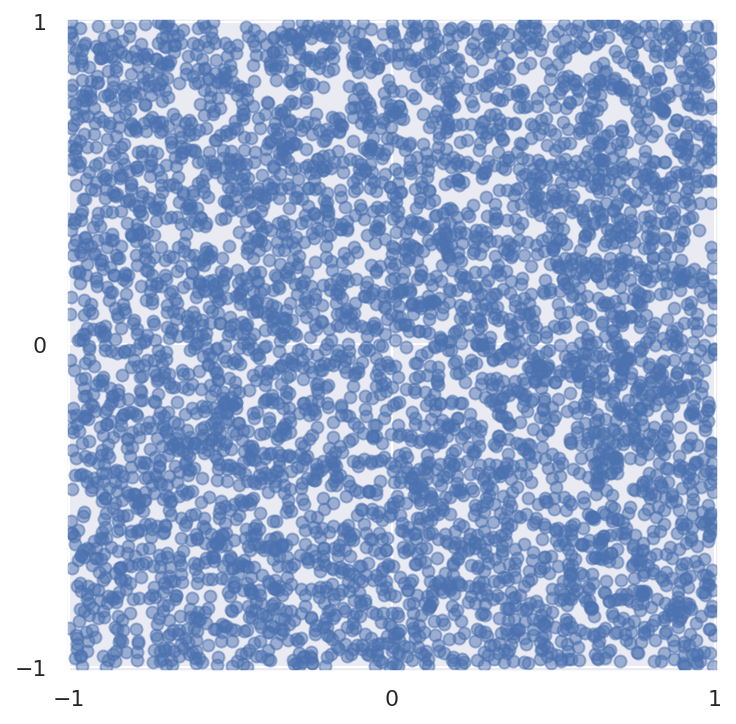

In [8]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ax.scatter(x, y, alpha=0.5);

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

Consider the points that fall inside the unit circle centered at the origin, $x^2 + y^2 < 1$.

In [9]:
in_circle = x**2 + y**2 < 1

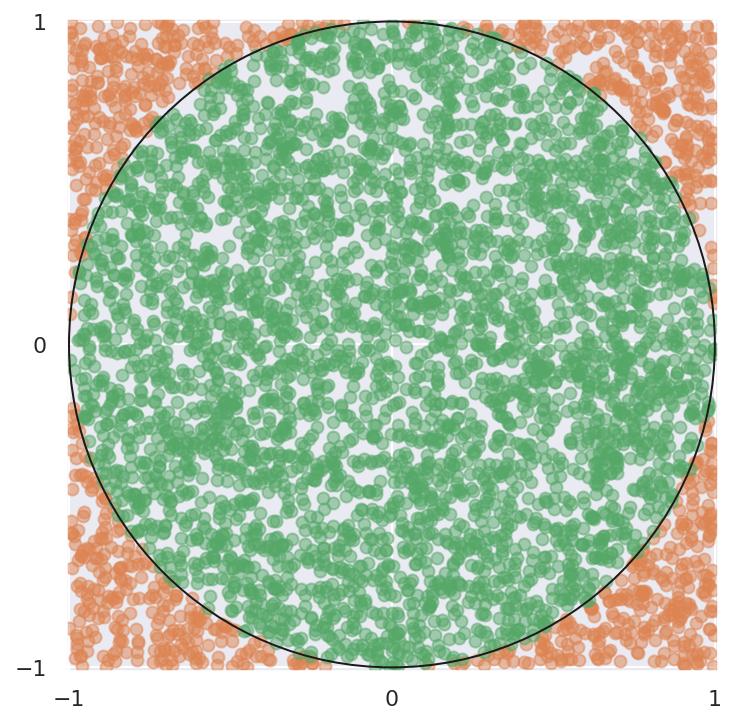

In [10]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ax.scatter(x[~in_circle], y[~in_circle], c='C1', alpha=0.5);
ax.scatter(x[in_circle], y[in_circle], c='C2', alpha=0.5);

ax.add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor='k'));

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

What fraction of these 5,000 points lie inside the unit circle?  Intuitively it should be the ratio of area of the circle, $\pi \cdot 1^2 = \pi$, to the area of the square, $2^2 = 4$.  We see that four times the proportion of random points that lie in the circle gives a decent approximation of $\pi$.

In [11]:
4 * in_circle.mean()

3.1488

Here we have used geometric reasoning to arrive at a Monte Carlo approximation of the integral

$$\pi = 4 \int_0^1 \sqrt{1 - x^2}\ dx.$$

The integral corresponds to a quarter of the area of the circle, so four times its value is $\pi$.

## Probabilistic programming with PyMC

With these three motivating perspectives in hand, we are ready to put theory into action by using PyMC to solve a problem that is nontrivial, but that we can still answer with pen and paper.  In my experience, recreating known results with a new technique is vital building the confidence to apply that technique to novel situations.

### The Monty Hall problem

[Let's Make a Deal](https://en.wikipedia.org/wiki/Let%27s_Make_a_Deal) is an American game show that had its first broadcast run on NBC and ABC from 1963 to 1976.  In (an idealized version of) one segment the show's host, [Monty Hall](https://en.wikipedia.org/wiki/Monty_Hall), presented the contestant with three doors, two of which led to goats and one of which led to a sports car.  The contestant would win whichever "prize" was behind the door they eventually opened.  Monty would ask the contestant to choose a door, but before revealing the prize behind it, he would open one of the other two doors to reveal a goat.  After showing the contestant the goat, he would offer the contestant the chance to switch their choice of door.

![The Monty Hall problem; three doors one open revealing a goat](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png)

The famed [Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) asks whether the contestant should switch their choice of door in order to maximize the probability that they win the sports car and not one of the goats.  To the befuddlement of many probability and statistics students, the answer is yes, the contestant should switch their choice of doors after Monty opens one.  This result is counterintuitive at first, but arises from the fact that Monty knows which prize is behind each door.  He will always show the contestant a goat after they make their initial choice (otherwise there would be no drama for the television viewers), and this fact transfers enough of his knowledge to the contestant to make switching the correct choice.

We will first solve the Monty Hall problem through exact calculation, then show how to derive the same answer with PyMC using probabilistic programming techniques.  For the sake of this example, suppose the contestant initially chose the first door and Monty opened the third door to reveal a goat (this situation is shown above).  Initially we have no information about which door the car is behind so

$$P(\text{Car behind 1}) = P(\text{Car behind 2}) = P(\text{Car behind 3}) = \frac{1}{3}.$$

The following table shows which door Monty can open after the contestant's initial choice based on the true location of the car, which he knows.
 
<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Given car behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 3</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In two of three cases (when the car is behind the second or third door), Monty has no choice of which door to open if he wants to maintain suspense for the viewing audience.  These are the cases where his choice gives us enough information to make switching doors the correct choice.

The following table translates the previous one into conditional probabilities.

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Probability Monty opens</center></th>
    </tr>
    <tr>
        <th>Given car behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td>0</td>
        <td>$\frac{1}{2}$</td>
        <td>$\frac{1}{2}$</td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Door 3</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
    </tr>
</table>

The second entry in the first row corresponds to

$$P(\text{Monty opens 2}\ |\ \text{Car behind 1}) = \frac{1}{2},$$

and other entries can be interpreted similarly.

Using Bayes' theorem,

$$P(\text{Car behind 1}\ |\ \text{Monty opens 3}) = \frac{P(\text{Monty opens 3}\ |\ \text{Car behind 1}) \cdot P(\text{Car behind 1})}{P(\text{Month opens 3})}.$$

The terms in the numerator are easy to calculate given our prior ignorance of the location of the prize and the table above,

$$
\begin{align*}
P(\text{Car behind 1})
    & = \frac{1}{3}\text{ and} \\
P(\text{Monty opens 3}\ |\ \text{Car behind 1})
    & = \frac{1}{2}.
\end{align*}
$$

Using the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability), the denominator is

$$
\begin{align*}
P(\text{Month opens 3})
    & = P(\text{Monty opens 3}\ |\ \text{Car behind 1}) \cdot P(\text{Car behind 1}) \\
    &\ \ \ \ \ \ + P(\text{Monty opens 3}\ |\ \text{Car behind 2}) \cdot P(\text{Car behind 2}) \\
    &\ \ \ \ \ \ + P(\text{Monty opens 3}\ |\ \text{Car behind 3}) \cdot P(\text{Car behind 3}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3} \\
    & = \frac{1}{2}.
\end{align*}
$$

Finally,

$$
\begin{align*}
P(\text{Car behind 1}\ |\ \text{Monty opens 3})
    & = \frac{P(\text{Monty opens 3}\ |\ \text{Car behind 1}) \cdot P(\text{Car behind 1})}{P(\text{Month opens 3})} \\
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{2}}
      = \frac{1}{3}.
\end{align*}
$$

Since the car is behind the first or second door with probability one,

$$P(\text{Car behind 2}\ |\ \text{Monty opens 3}) = \frac{2}{3},$$

and the contestant doubles their chances of winning the sports car by switching doors.

These calculations were tedious but not particularly hard.  Given that [computers are great at automating the boring stuff](https://automatetheboringstuff.com/), we'll now see how to arrive at the same answer by telling the story of how Monty chooses which door to open in code and then allowing PyMC to (approximately) calculate the probability the car is behind each door.

![Automate the Boring Stuff with Python](https://automatetheboringstuff.com/images/cover_automate2_thumb.jpg)

We begin by importing PyMC.

In [12]:
import pymc as pm

Initially we have no idea which door the car is behind, so we treat each possibility as equally likely.  (Note that we will use zero-indexed doors in our code; the first door is door number zero, the second door is door number one, and the third door is door number two in this code.)

In [13]:
with pm.Model(rng_seeder=SEED) as monty_model:
    car = pm.DiscreteUniform("car", 0, 2)

Here we have created a PyMC model using the [`Model`](https://docs.pymc.io/en/latest/api/model.html#pymc.model.Model) context manager.  It is helpful to think of a PyMC `Model` as container for the story about how our data was generated.  The [`DiscreteUniform` distribution](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.DiscreteUniform.html#pymc.DiscreteUniform) tells PyMC that there is a one-third chance the car is behind each of the doors.

We now express the conditional probability that Monty opens each door given the location of the car in code.

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Probability Monty opens</center></th>
    </tr>
    <tr>
        <th>Given car behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td>0</td>
        <td>$\frac{1}{2}$</td>
        <td>$\frac{1}{2}$</td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Door 3</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
    </tr>
</table>

In [14]:
from aesara import tensor as at

In [15]:
p_open = at.switch(
    at.eq(car, 0),
    np.array([0, 0.5, 0.5]), # it is behind the first door
    at.switch(
        at.eq(car, 1),
        np.array([0, 0, 1]), # it is behind the second door
        np.array([0, 1, 0])  # it is behind the third door
    )
)

This code looks a bit odd at first, but is easy to interpret with a bit of guidance.  The Aesara function [`switch`](https://aesara.readthedocs.io/en/latest/library/tensor/basic.html#aesara.tensor.switch) acts like an if statement, evaluating the condition in its first argument, returning its second argument if that condition is true and its third argument otherwise.  The Aesara function [`eq`](https://aesara.readthedocs.io/en/latest/library/tensor/basic.html#aesara.tensor.eq) is a simple test of equality.  We will return to the question of why we choose to define `p_open` using Aesara instead of directly using Python's built in `if`/`else` and `==` constructs after this example.

So far we have expressed our initial ignorance about the location of the car and Monty's process for deciding which door to open in code.  All that remains is to specify that he did, in fact, open the third door.

In [16]:
with monty_model:
    opened = pm.Categorical("opened", p_open, observed=2)

The most notable part of this code is `observed=2` argument passed to the [`Categorical` distribution](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Categorical.html), which tells PyMC that Monty opened the third door.

With `opened` specified, we are ready to have PyMC perform inference and get a Monte Carlo approximation of the probability that the car is behind each door given that contestant intially chose the first one and Monty opened the third one.

In [17]:
with monty_model:
    monty_trace = pm.sample()

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [car]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


After performing Monte Carlo inference using this model (colloquially refered to as "sampling"), we are left with 2,000 draws of the location of the car.

In [18]:
monty_trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    car      (chain, draw) int64 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 1 1 0 1 1 1 1 1
Attributes:
    created_at:                 2022-01-29T21:16:50.658094
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b1
    sampling_time:              1.873450756072998
    tuning_steps:               1000

By counting the proportion of samples that are equal to zero we can see whether or not the contestant should switch their choice of door.

In [19]:
(monty_trace.posterior["car"] == 0).mean()

<xarray.DataArray 'car' ()>
array(0.314)

We see that our Monte carlo approximation is quite close to the true probability that the car is behind the first door we calculated above, $\frac{1}{3}$.  The relevant posterior probabilities are shown graphically below.

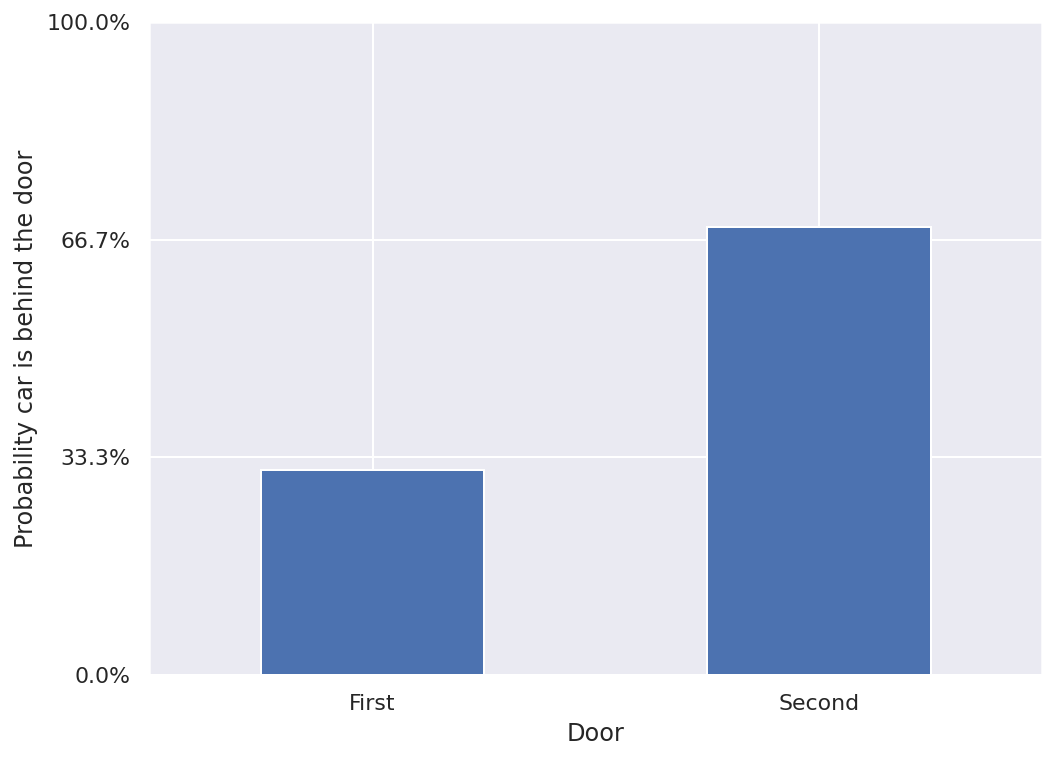

In [20]:
ax = (monty_trace.posterior["car"]
                 .to_dataframe()
                 .value_counts(normalize=True, sort=False)
                 .plot.bar(rot=0))

ax.set_xticklabels(["First", "Second"]);
ax.set_xlabel("Door");

ax.set_yticks(np.linspace(0, 1, 4));
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability car is behind the door");

Recreating the known solution to the Monty Hall problem gives us confidence to proceed to more complex problems with probabilistic programming.  Before we do so we highlight two important components of PyMC that we have used to solve this problem.

### PyMC distributions

Both the [`DiscreteUniform`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.DiscreteUniform.html) and [`Categorical`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Categorical.html) objects above are examples of [PyMC distributions](https://docs.pymc.io/en/latest/api/distributions.html).  PyMC provides implementations of dozens of [probability distributions](https://en.wikipedia.org/wiki/Probability_distribution) out ot of the box.  These distributions are the building blocks we build our models.  In the Monty Hall problem, the `DiscreteUniform` distribution expressed the fact that we had no reason to believe any door was more likely to contain the car than the others before Monty opened one of them. The `Categorical` distribution expressed that he only opened a single door with probability given by `p_open`.

![Lego bricks](https://media4.giphy.com/media/xUA7b0Klw8Wfor7FWo/giphy.gif)

The probability distributions PyMC provides range from commonly the used [normal](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Normal.html) and [Poisson](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Poisson.html) distributions

![Normal distribution probability density functions](https://docs.pymc.io/en/latest/_images/pymc-Normal-1.png)

![Poisson distribution probability mass functions](https://docs.pymc.io/en/latest/_images/pymc-Poisson-1.png)

to the less frequently used [zero-inflated binomial](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.ZeroInflatedNegativeBinomial.html) and [Kumaraswamy](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Kumaraswamy.html) distributions.

![Zero inflated negative binomial distribution probability mass functions](https://docs.pymc.io/en/latest/_images/pymc-ZeroInflatedNegativeBinomial-1.png)

![Kumaraswamy distribution probability density functions](https://docs.pymc.io/en/latest/_images/pymc-Kumaraswamy-1.png)

It is straightforward to implement new distributions following the example of existing distributions.  Implementing a new distribution is often a good first contribution to PyMC because the effort can be relatively small and self-contained.

### Aesara

When defining `p_open` for the Monty Hall problem we briefly mentioned [Aesara](https://aesara.readthedocs.io/en/latest/).  Aesara is the tensor computation library that PyMC uses for mathematical calculations.  It fills a niche in the data science software ecosystem that is similar to [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/).

![Aesara logo](https://github.com/aesara-devs/aesara/raw/main/doc/images/aesara_logo_2400.png)

From the Aesara documentation:

> Aesara is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. Aesara features:
>
> * Tight integration with NumPy – Use numpy.ndarray in Aesara-compiled functions.
> * Efficient symbolic differentiation – Aesara does your derivatives for functions with one or many inputs.
> * Speed and stability optimizations – Get the right answer for log(1+x) even when x is really tiny.
> * Dynamic C/JAX/Numba code generation – Evaluate expressions faster.
> * Aesara is based on Theano, which has been powering large-scale computationally intensive scientific investigations since 2007.

PyMC relies on each of these features of Aesara in the implementation its Monte Carlo samplers to varying degrees.  The second point is most important for the purposes of this introduction.  Stated more plainly, Aesara automates calculus for us so our Monte Carlo approximation algorithms can use information about the gradient of the probability distributions form the model in order to sample efficiently.  This increased efficiency using Aesara-generated gradients that makes us willing to tolerate the definition of `p_open` above which is somewhat awkward compared to the equivalent Python `if`/`else` and `==` implementation.

#### Automating calculus

Recall from calculus that

$$\frac{d}{dx} \left(x^3\right) = 3 x^2.$$

We can derive this result using Aesara as follows.  First we define a scalar variable $x$,

In [21]:
x = at.scalar("x")

Then we let $y = x^3$,

In [22]:
y = x**3

We now ask aesara to differentiate `y` with respect to `x`

In [23]:
pprint(at.grad(y, x))

'((fill((x ** 3), 1.0) * 3) * (x ** (3 - 1)))'

Squinting a bit, `fill((x ** 3), 1.0)` becomes `(1.0**3)` becomes `1` when we substitute ("fill") one for `x`, so the result simplifies to $3 x^2$ as expected.  This example is obviously simple, but Aesara truly shines when the function to be differentiated is complex and involves many inputs.  Such complex functions arise naturally from modern models of complex phenomena.

#### Hamiltonian Monte Carlo, the curse of dimensionality, and differential geometry

PyMC uses Aesara for automatic gradient computation in order to implement a class of Monte Carlo algorithms known as _Hamiltonian_ Monte Carlo algorithms.  These algorithms take their inspiration from the field of [Hamiltonian mechanics](https://en.wikipedia.org/wiki/Hamiltonian_mechanics) in physics.  They are essential for performing inference on realistic models with many parameters.  To understand why, we consider the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  From Wikipedia,

> The curse of dimensionality refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience.

One geometric interpretation of the curse of dimensionality is that as the number of dimensions grows, the volume of the hypersphere of radius one goes to zero quickly, as shown below.

In [24]:
ndim = np.linspace(1, 1_000)
vol = 2. * np.power(np.pi, ndim / 2.) / ndim / sp.special.gamma(ndim / 2)

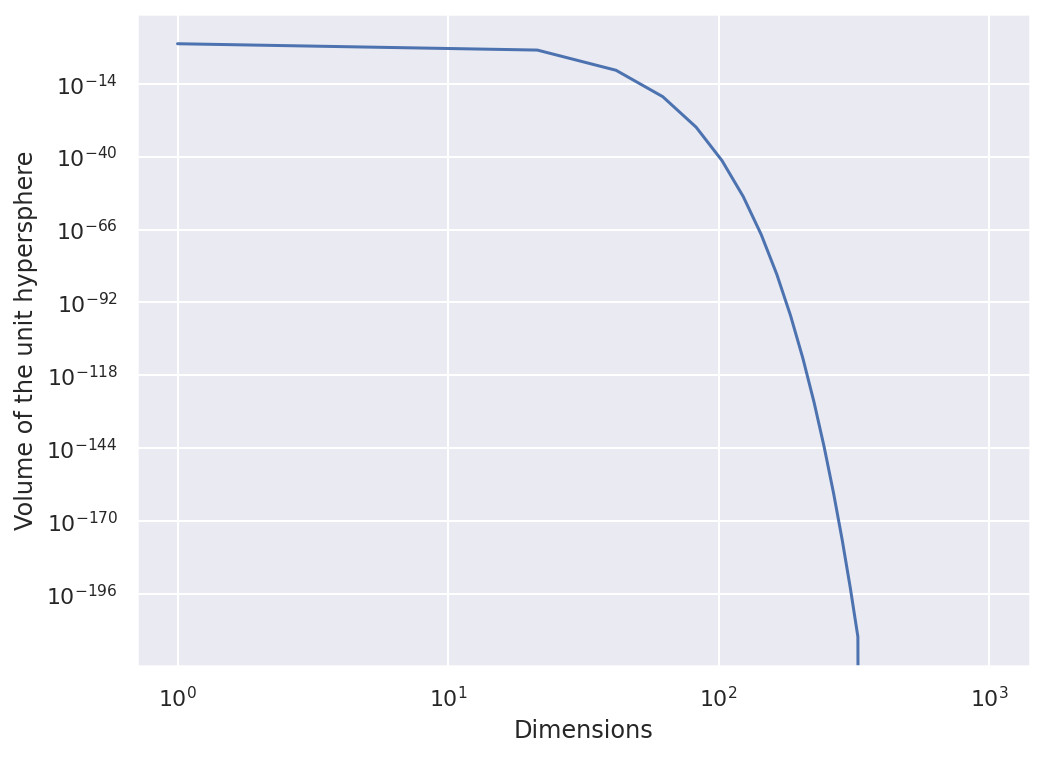

In [25]:
fig, ax = plt.subplots()

ax.plot(ndim, vol);

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_yscale('log');
ax.set_ylabel("Volume of the unit hypersphere");

In probabilistic programming, the number of dimensions corresponds to the number of unknown parameters in our model.  Though the Monty Hall problem has only one unknown parameter (the location of the prize), models used in applied work can easily have hundreds or thousands of parameters.  The final example of this post will be a relatively straightforward model that still contains hundreds of parameters.

Rephrased in terms of probability, the curse of dimensionality says if we draw a point at random from the unit hypercube, the probability that it is in the unit hypersphere quickly goes to zero as the number of dimensions increases.

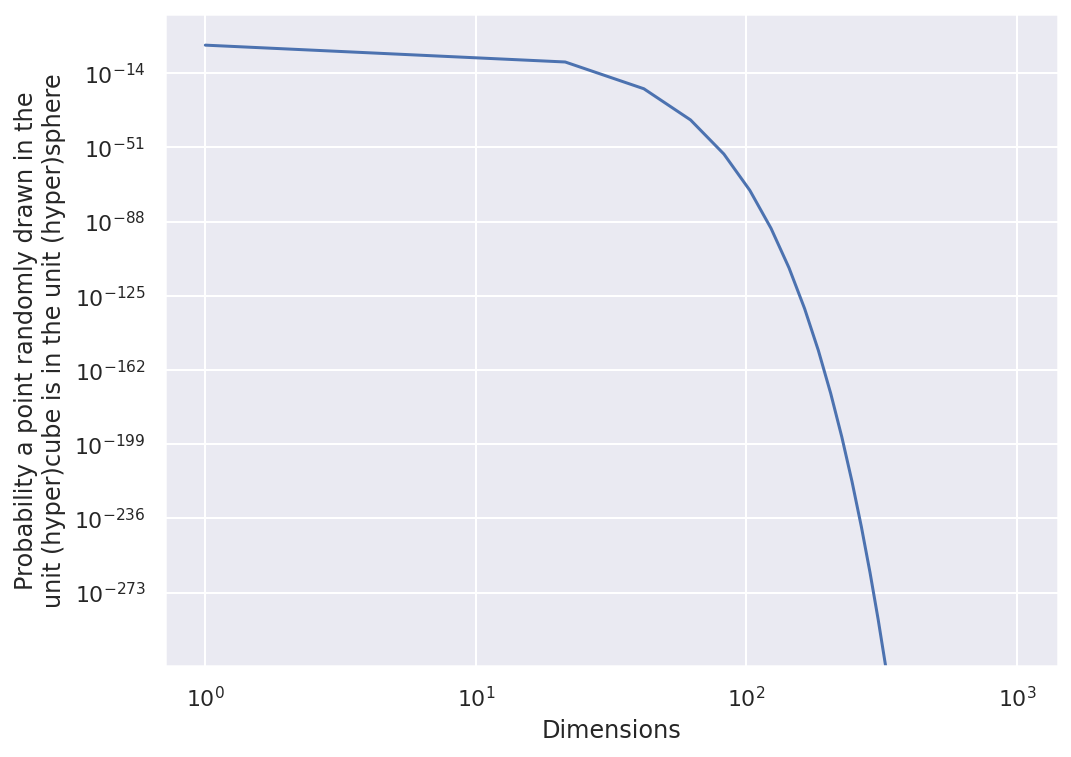

In [26]:
cod_fig, cod_ax = plt.subplots()

cod_ax.plot(ndim, vol / 2**ndim);

cod_ax.set_xscale('log');
cod_ax.set_xlabel("Dimensions");

cod_ax.set_yscale('log');
cod_ax.set_ylabel("Probability a point randomly drawn in the\n"
                  "unit (hyper)cube is in the unit (hyper)sphere");

The Monte Carlo approximations used in probabilistic programming work by identifying regions of the parameter space that contain most of the posterior probability and spending more time sampling in those regions than in others.  In high dimensions, the curse of dimensionality makes these high posterior probability regions much more difficult to locate.

Using information about the curvature of the likelihood function of a model makes it easier to locate these regions of high posterior probability.  [Differential geometry](https://en.wikipedia.org/wiki/Differential_geometry) provides the mathematical machinery to quantify the curvature of a hypersurface in terms of derivatives.

![A torus with areas of positive and negative curvature](https://upload.wikimedia.org/wikipedia/commons/3/38/Torus_Positive_and_negative_curvature.png)

The excellent paper [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) provides a thorough and clear introduction to the concepts of differential geometry that are most relevan to Hamiltonian Monte Carlo algorithms.  The author, [Michael Betancourt](https://betanalpha.github.io/), is a key [Stan](https://mc-stan.org/) contributor and his [online writings](https://betanalpha.github.io/writing/) are also excellent resources for learning more about probabilistic programming in general.

The final example in this post will illustrate the importance of Hamiltonian Monte Carlo algorithms in modern probabilistic programming.

### Robust regression

The Monty Hall problem provided an excellent case study for making the theory of probabilistic programming tangible.  We now turn to a slightly more realistic example to gain more experience doing probabilistic programming with PyMC.

#### Anscombe's quartet

[Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is an interesting group of four data sets that share  nearly identical descriptive statistics while in fact having very different underlying relationships between the independent and dependent variables.  The following code for visualizing Anscombe's quartet is adapted from the [Matplotlib documentation](https://matplotlib.org/stable/gallery/specialty_plots/anscombe.html).

In [27]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5], dtype=np.float64)
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

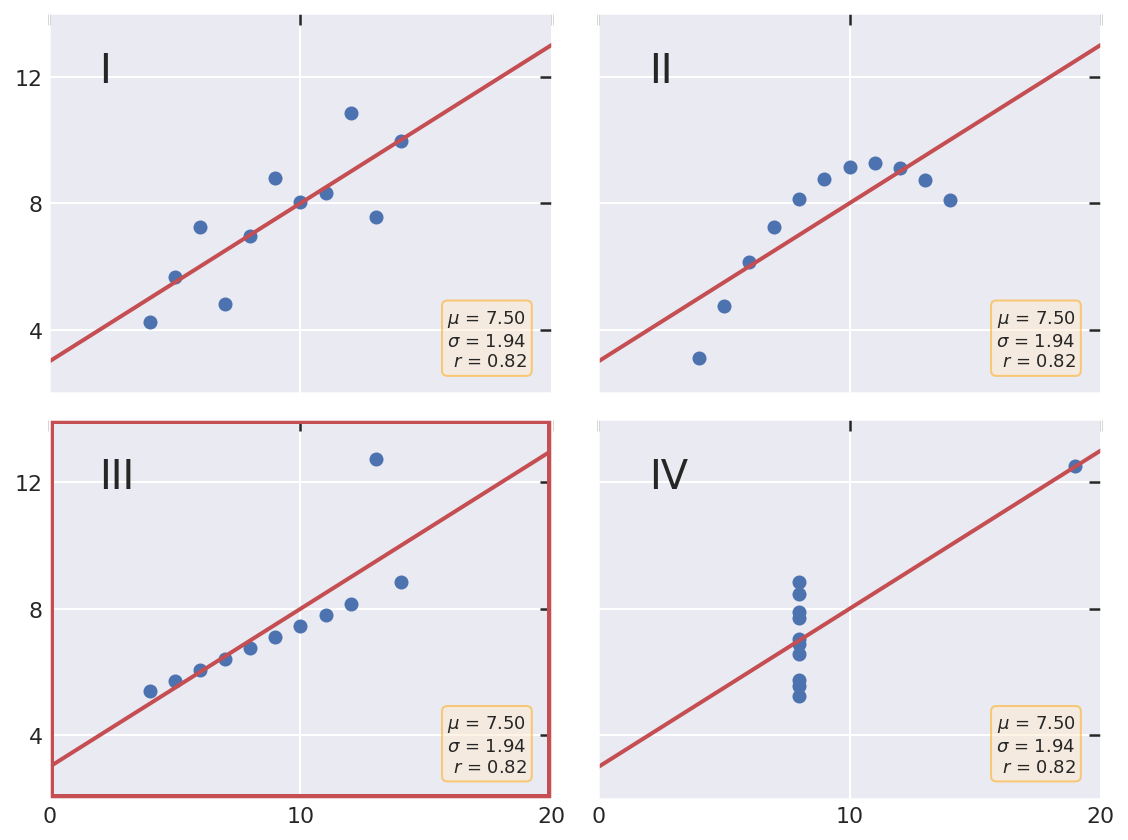

In [28]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

for ax, (label, (x_, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x_, y, 'o')

    # linear regression
    p1, p0 = np.polyfit(x_, y, deg=1)  # slope, intercept
    ax.axline(xy1=(0, p0), slope=p1, color='r', lw=2)

    # add text box for the statistics
    stats = (f'$\\mu$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$r$ = {np.corrcoef(x_, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')
    
axs[1, 0].add_artist(plt.Rectangle((0, 2), 20, 12, fill=False, edgecolor='r', lw=5));

fig.tight_layout();

Anscombe's quartet is an excellent teaching tool; for the purposes of implementing robust regression in PyMC we will focus on the third data set highlighted above and plotted on its own below, together with the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) line fit to these data using [NumPy's `polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).

In [29]:
m_ols, b_ols = np.polyfit(x, y3, deg=1)

In [30]:
def plot_line(m, b, *, ax, **kwargs):
    ax.axline((0, b), slope=m, **kwargs)
    
    return ax

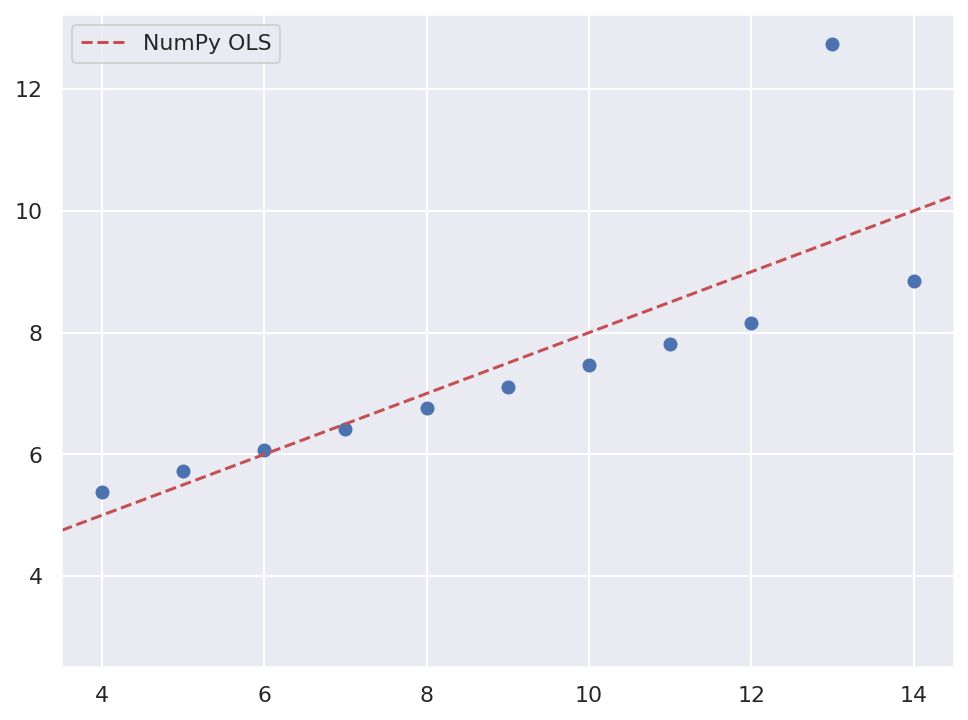

In [31]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

This data set is useful for our purposes because all the points lie exactly on a line except for one outlier.  That "robust" line is shown below.

In [32]:
is_outlier = x == 13

m_robust, b_robust = np.polyfit(x[~is_outlier], y3[~is_outlier], deg=1)

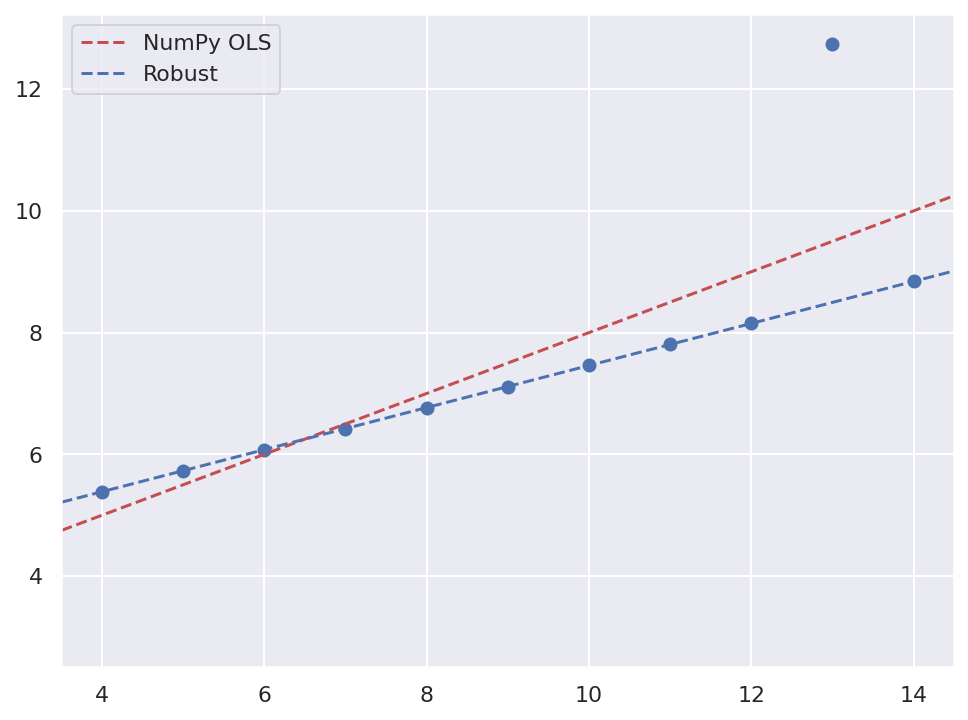

In [33]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);

plot_line(m_robust, b_robust, ls='--', label="Robust", ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

Our goal is to recover the robust line using PyMC.  We will iterate through a few models before we do so.

#### Ordinary least squares

We begin by recovering not the robust line, but the NumPy OLS line for simplicity.  Though the OLS estimator is often derived as the linear transformation that minimizes the mean squared residuals of the observed data, an [equivalent definition](https://en.wikipedia.org/wiki/Ordinary_least_squares#Maximum_likelihood) is that it is the (linear) [maximum likelihood estimator](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) when the residuals are assumed to be normally distributed.  This equivalent definition is the appropriate one for use with PyMC.

We assume all valid values $m, b \in \mathbb{R}$ and $\sigma > 0$ are equally likely.

In [34]:
with pm.Model(rng_seeder=SEED) as ols_model:
    m = pm.Flat("m")
    b = pm.Flat("b")
    
    σ = pm.HalfFlat("σ")

Here [`Flat`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Flat.html) assigns all real numbers a log probability of zero, and similarly [`HalfFlat`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.HalfFlat.html) assigns all positive real numbers a log probability of zero.  (These are not proper probability distributions.  There is no uniform distribution on all real numbers or on all positive real numbers.  Still, these [improper distributions](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors) work computationally in certain cases.)

The fact that our model is linear means that

$$y = m \cdot x + b + \varepsilon,$$

where $\varepsilon \sim N(0, \sigma^2)$.  This form is mathematically equvalent to

$$y \sim N(m \cdot x + b, \sigma^2).$$

In PyMC, distribution of the observed data becomes

In [35]:
with ols_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)

Unlike in typical mathematical notation, $N\left(\mu, \sigma^2\right)$, that specifies the variance $\sigma^2$, PyMC's [`Normal`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Normal.html) expects the scale (standard deviation), $\sigma$, as its second argument. This small difference aside, one of the aspects of PyMC that I find particularly compelling is that its syntax is quite close to the mathematical specification of a model.

Finally we are ready to sample from this model's posterior distribution and check it against NumPy's OLS result.

In [36]:
CORES = 3

SAMPLE_KWARGS = {
    'cores': CORES,
    'random_seed': (SEED + np.arange(CORES)).tolist()
}

In [37]:
with ols_model:
    ols_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4399, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Immediately PyMC provides quite a bit of information.  We see a few warnings about divergences, acceptance probabilities, and effective samples.  We will discuss a few of these ideas in the following section, and provide resources to learn more about those we do not discuss at the end of this post.

First, however, we visualize the results of inference with this model.

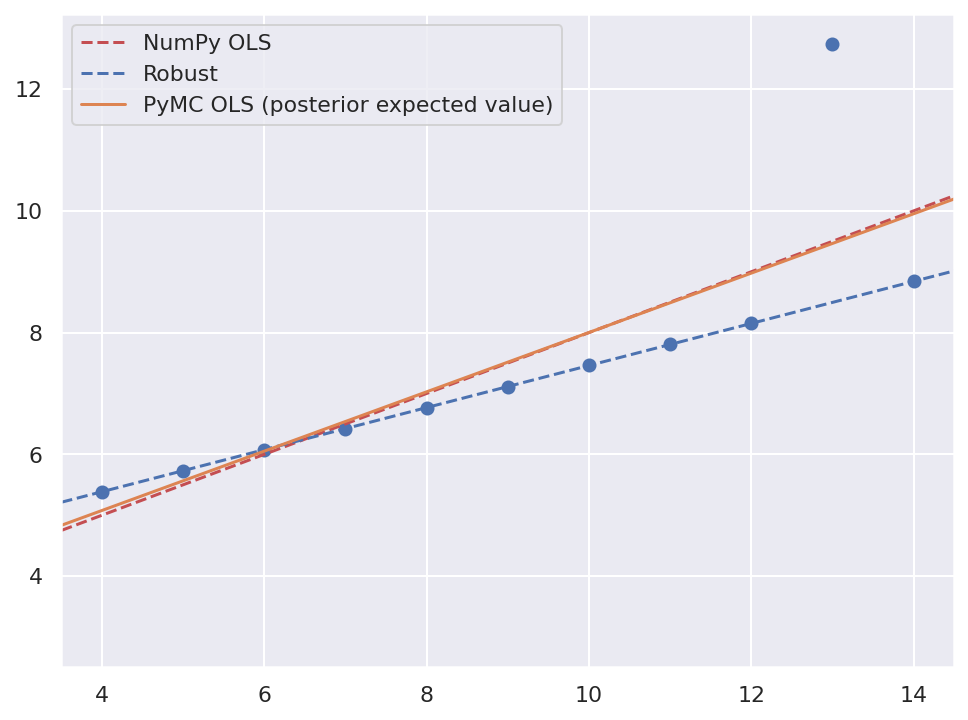

In [38]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);

plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

ax.set_xlim(3.5, 14.5);

ax.legend();

We see that PyMC's OLS result agrees quite closely with NumPy's OLS result.  One of the advantages of Bayesian inference with PyMC is that we get built-in estimates of uncertainty for our results.  Below we plot not only the posterior expected value of PyMC's OLS estimate, but also a few individual realizations of the posterior distribution.

In [39]:
THIN = 50

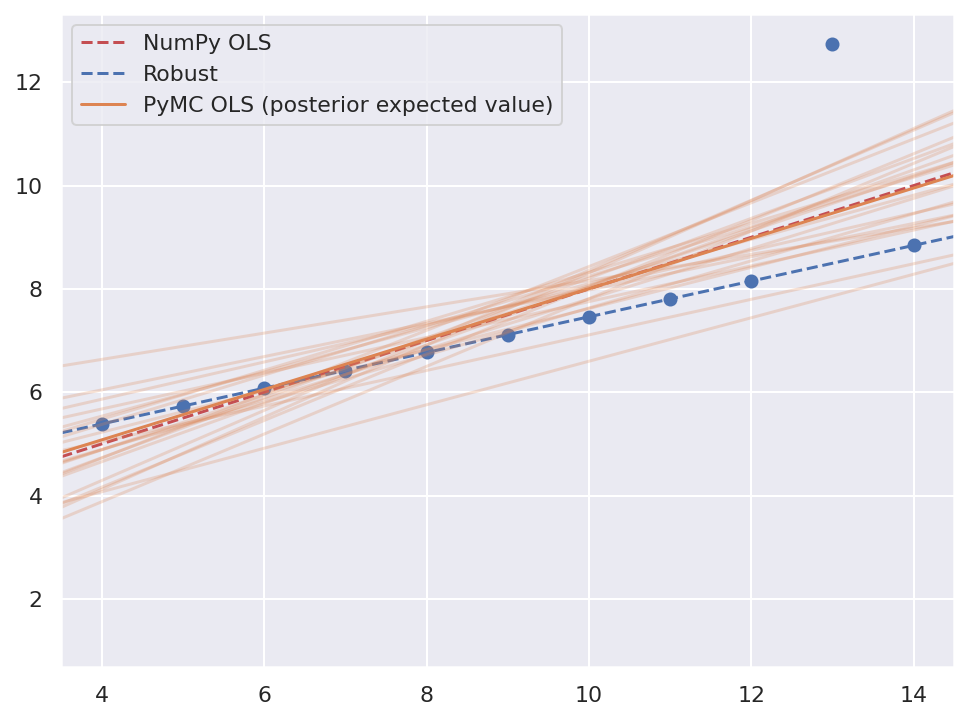

In [40]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);

plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

for m, b in (ols_trace.posterior[["m", "b"]]
                      .sel(chain=0)
                      .thin(THIN)
                      .to_array().T):
    plot_line(m.values, b.values, c='C1', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

These samples show some interesting behavior.  Most of the posterior samples are fairly close to the posterior expected value, but one or two are significantly lower and closer to the true behavior of the non-outliers.

We visualize the posterior distributions of $m$ and $b$ and see where the true robust values fall in those distributions.

In [41]:
import arviz as az

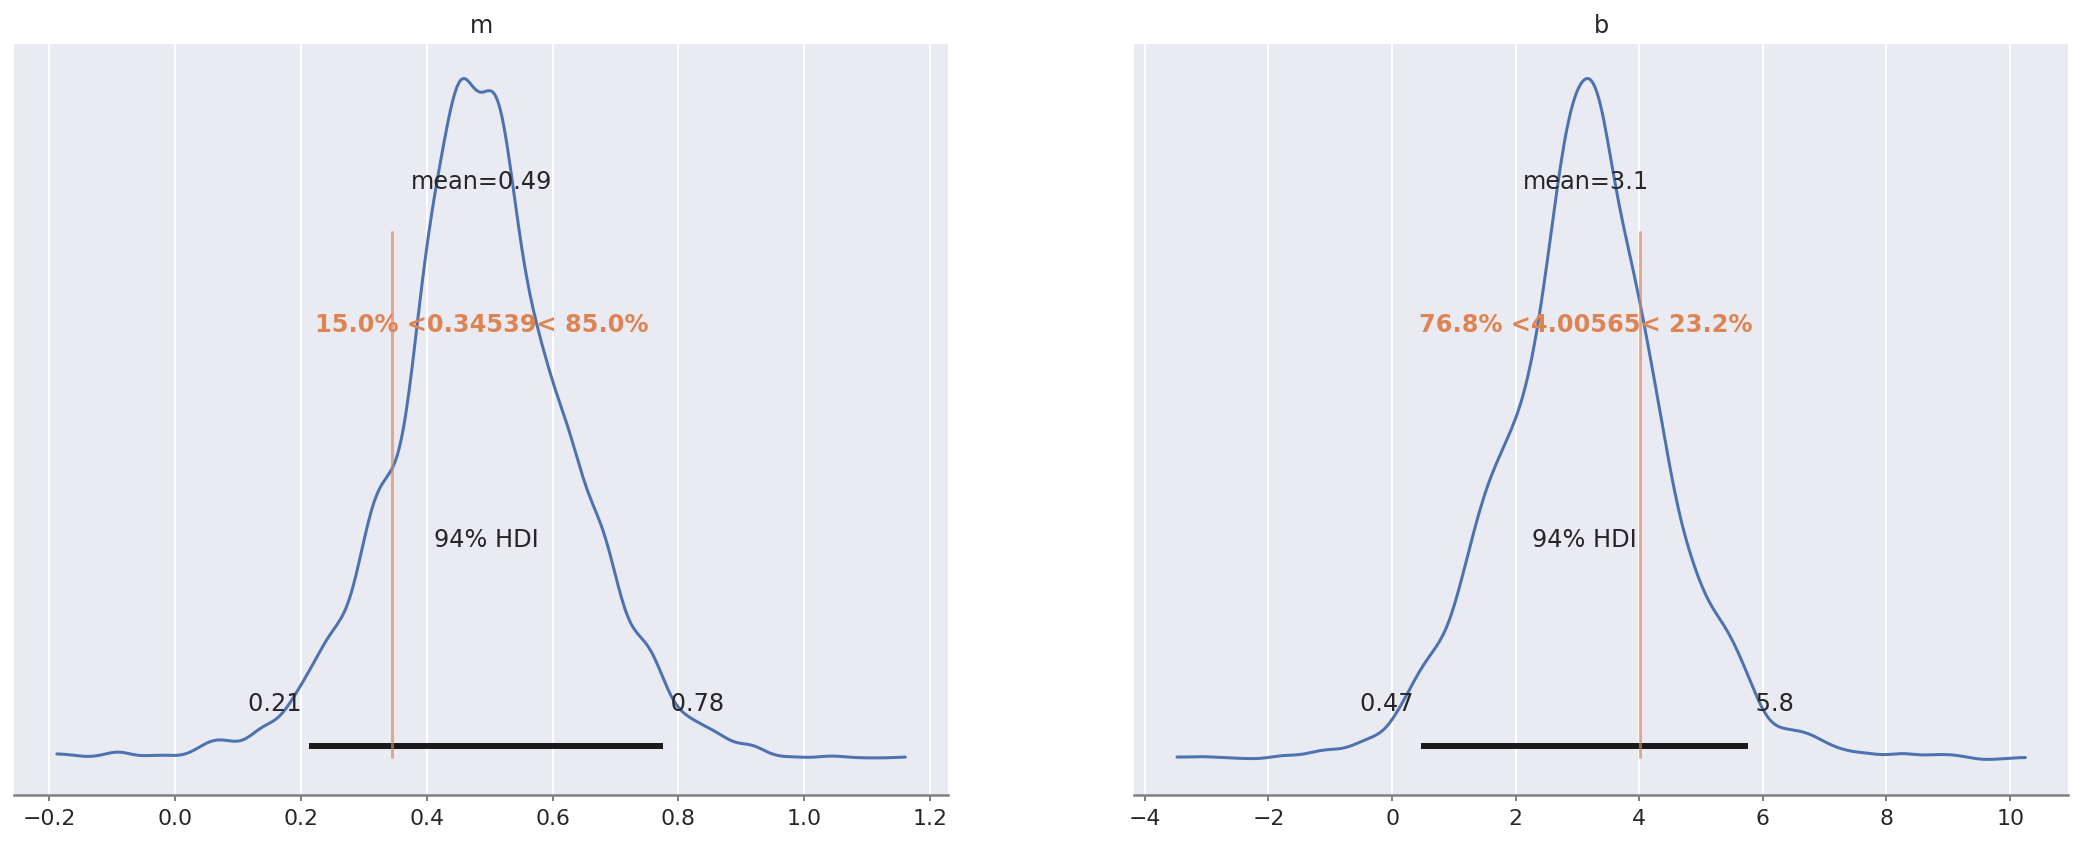

In [42]:
az.plot_posterior(ols_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

The posterior distribution of the slope tends to overestimate the true robust value and that of the intercept tends to underestimate the truth.  This behavior makes sense in the presence of the outlier.  Since its $y$-value is significantly higher than the robust trend would indicate, its presence causes the the slope to be overestimated, which causes the intercept to be underestimated to compensate.

Before we iterate on this model to improve its roustness, we pause to highlight two more of the key components of the PyMC ecosystem that we have just encountered.

#### ArviZ

[ArviZ](https://arviz-devs.github.io/arviz/) is the package we used to produce the posterior visualization above for our OLS model in one line of code.

![ArviZ logo](https://arviz-devs.github.io/arviz/_static/logo.png)

From the ArviZ documentation:

> ArviZ is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.
>
> The goal is to provide backend-agnostic tools for diagnostics and visualizations of Bayesian inference in Python, by first converting inference data into xarray objects. See [here](https://xarray.pydata.org/en/stable/) for more on xarray and ArviZ usage and here for more on InferenceData structure and specification.ArviZ is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.
>
> The goal is to provide backend-agnostic tools for diagnostics and visualizations of Bayesian inference in Python, by first converting inference data into xarray objects. See here for more on xarray and ArviZ usage and here for more on InferenceData structure and specification.

Because probabilistic programming is so tightly intertwined with Bayesian inference, many of the visualizations and statistical calculations are not useful for only one probabilistic programming library/language.  ArviZ defines a standardized format for probabilistic programming libraries in which to store the results of inference.  For any results in this standardized format, ArviZ provides many functions to perform statistical calculations and produce visualizations. Examining the type of `ols_trace`, we see that it is an ArviZ `InferenceData` object.

In [43]:
type(ols_trace)

arviz.data.inference_data.InferenceData

In addition to the posterior visualization above, ArviZ also provides many diagnostic visualizations.  Below we use ArviZ to produce a [parallel plot](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_parallel.html) that highlights the divergences PyMC experienced during sampling.  These divergences are indicative of potential issues with convergence of our Monte Carlo approximations.

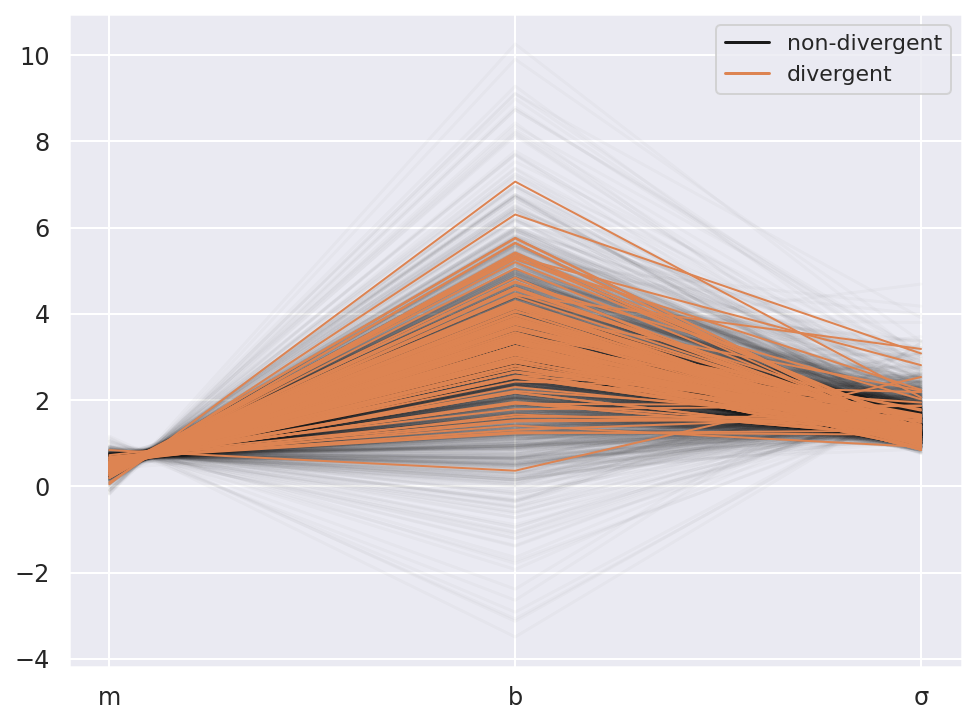

In [44]:
az.plot_parallel(ols_trace);

We will use several more ArviZ statistical functions and visualizations throughout the rest of this post.

#### Xarray

As the above quote from the ArivZ documentation emphasizes, [xarray](https://xarray.pydata.org/en/stable/) is the core data structure underlying ArviZ's `InferenceData` object.  The posterior component of `ols_trace` is in fact an xarray [`Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [45]:
type(ols_trace.posterior)

xarray.core.dataset.Dataset

![xarray logo](https://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png)

From the xarray documentation:

> xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!
>
> [...] 
>
> Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

We will see the real power that xarray lends to ArviZ and PyMC while analyzing Lego set prices in the final, most complex example in this post.

#### Bayesian Ridge Regression

Now that we have become acquainted with ArviZ and xarray, we return to the third data set in Anscombe's quartet and robust regression.  One way to introduce robustness in a statistical model is to add [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)).  In our OLS model, the priors on $m$, $b$, and $\sigma$ assign the same likelihood to all valid values of these parameters, so extremely large values are just as likely as small values.  We can change the prior distributions on these parameters to ones that assign higher probability to smaller (absolute) values as a form of regularization.  In fact, normal priors on $m$ and $b$ are [equivalent](https://en.wikipedia.org/wiki/Tikhonov_regularization#Bayesian_interpretation) to [ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).  The regularization parameter in ridge regression is related to the scale of the normal prior distributions on $m$ and $b$.

We now implement this Bayesian ridge regression model.  Let $m \sim N(0, 2.5^2)$ and $b \sim N(0, 10^2)$ (recall that in ridge regression it is common to regularize the intercept much less than the other coefficients, if at all; a larger prior scale corresponds to weaker regularization).

In [46]:
with pm.Model(rng_seeder=SEED) as ridge_model:
    m = pm.Normal("m", 0, 2.5)
    b = pm.Normal("b", 0., 10)

We let $\sigma$ have a [half-normal distribution](https://en.wikipedia.org/wiki/Half-normal_distribution), $\sigma \sim \text{Half-}N(2.5^2)$.

In [47]:
with ridge_model:
    σ = pm.HalfNormal("σ", 2.5)

The ease with which we can change the prior distributions on $m$, $b$, and $\sigma$ from the OLS model to get the ridge model is one of the strengths of probabilistic programming and PyMC.

The likelihood of the observed data is the same as in the OLS model.

In [48]:
with ridge_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)

We now sample from the ridge model's posterior distribution.

In [49]:
with ridge_model:
    ridge_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


We reduced the number of divergences during inference, but not eliminated them.

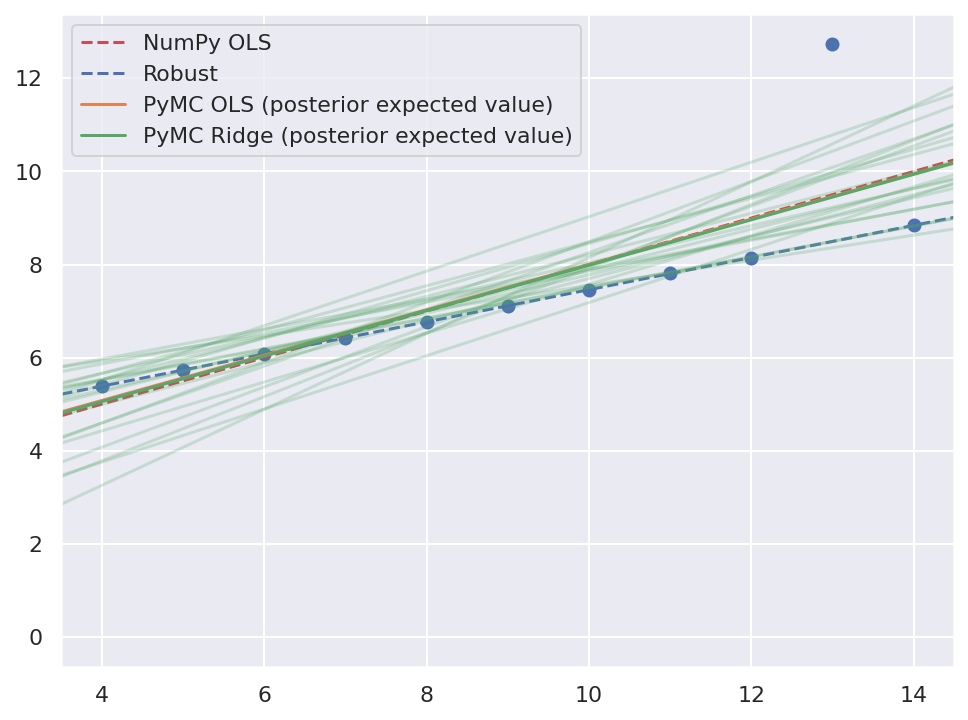

In [50]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);
plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);

plot_line(
    ridge_trace.posterior["m"].mean(dim=("chain", "draw")),
    ridge_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C2', label="PyMC Ridge (posterior expected value)", ax=ax
);

for m, b in (ridge_trace.posterior[["m", "b"]]
                        .sel(chain=0)
                        .thin(THIN)
                        .to_array().T):
    plot_line(m.values, b.values, c='C2', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

We see that the ridge regression result is not too different from the OLS result, so we have not effectively introduced robustness.  Upon reflection, this is due to the fact that regularization of this type is more effective when outliers appear in the $x$-values than in the $y$-values, which is the case for this data set.

The posterior visualization of $m$ and $b$ compared to their true robust values remains largely unchanged as well.

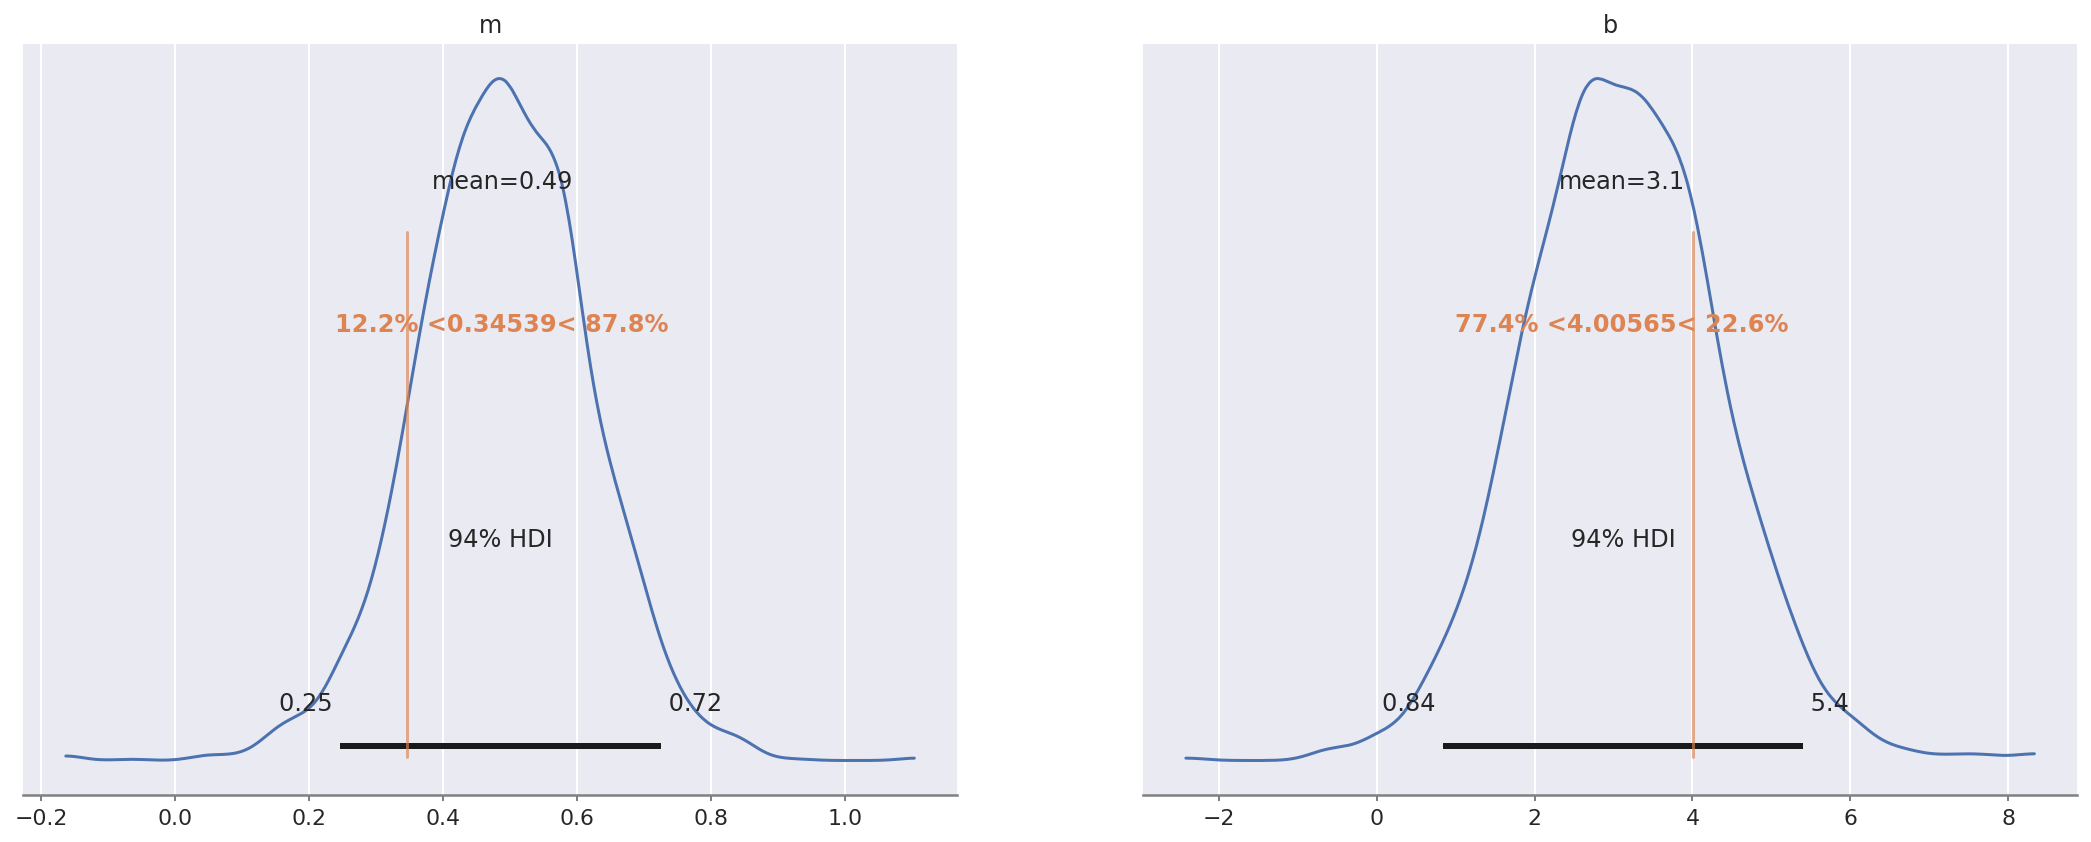

In [51]:
az.plot_posterior(ridge_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

#### <a id="Robust-regression-2">Robust regression</a>

To add robustness against outlier $y$-values, we change the distribution of the observations from a normal distribution to a [fatter-tailed distribution](https://en.wikipedia.org/wiki/Fat-tailed_distribution).  [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) has a shape similar to that of the normal distribution, but with fatter tails.

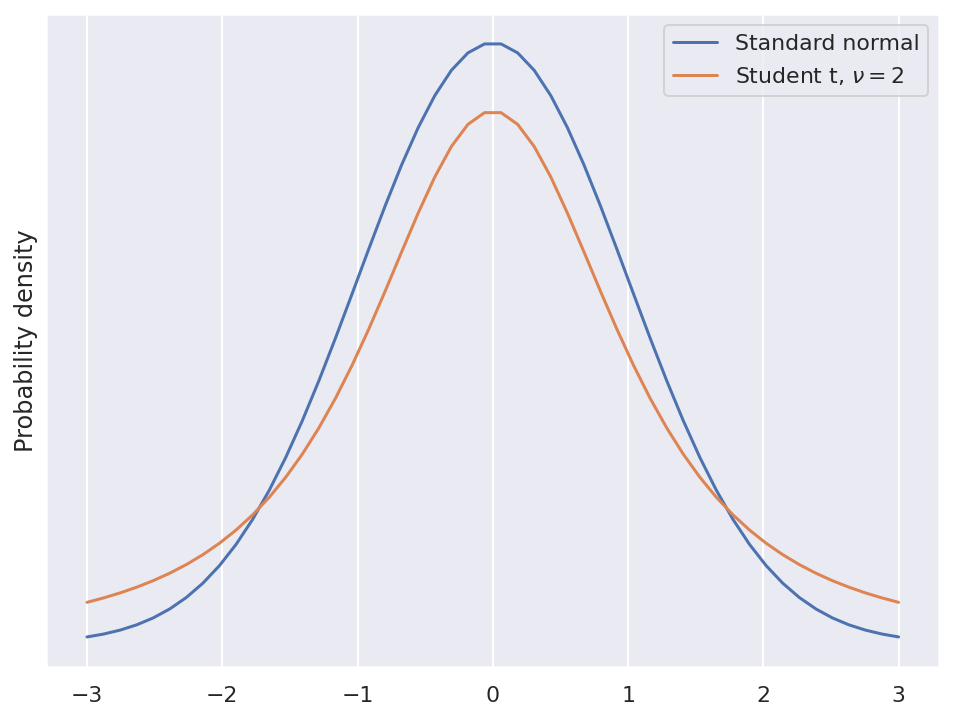

In [52]:
fig, ax = plt.subplots()

x_plot = np.linspace(-3, 3)
ax.plot(x_plot, sp.stats.norm.pdf(x_plot),
        label="Standard normal");

DF = 2
ax.plot(x_plot, sp.stats.t.pdf(x_plot, DF),
        label=f"Student t, $\\nu = {DF}$");

ax.set_yticks([]);
ax.set_ylabel("Probability density");

ax.legend();

These fatter tails make a Student t-likelihood more robust against outliers than a normal likelihood.

This model uses the same prior distributions on $m$, $b$, and $\sigma$ as the ridge model.

In [53]:
with pm.Model(rng_seeder=SEED) as robust_model:
    m = pm.Normal("m", 0, 2.5)
    b = pm.Normal("b", 0., 10)
    
    σ = pm.HalfNormal("σ", 2.5)

We place a uniform prior on the number of degrees of freedom of the Student t-likelihood, $\nu \sim U(1, 10)$.

In [54]:
with robust_model:
    ν = pm.Uniform("ν", 1, 10)

We restrict $\nu$ to be smaller than ten because as $\nu \to \infty$ the Student t-distribution converges to a normal distribution, negating the robustness we are hoping to introduce.

We now specify the likelihood of the observations and sample from this robust model.

In [55]:
with robust_model:
    y_obs = pm.StudentT("y_obs", nu=ν, mu=m * x + b, sigma=σ, observed=y3)
    
    robust_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [m, b, σ, ν]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6854, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


There were no divergences while sampling from this model, which is promising.  (Mismatched acceptance probabilites are easier to remedy than divergences.)

We see that the Student t-likelihood has enabled us to recover the true, robust trend, ignoring the single outlier.

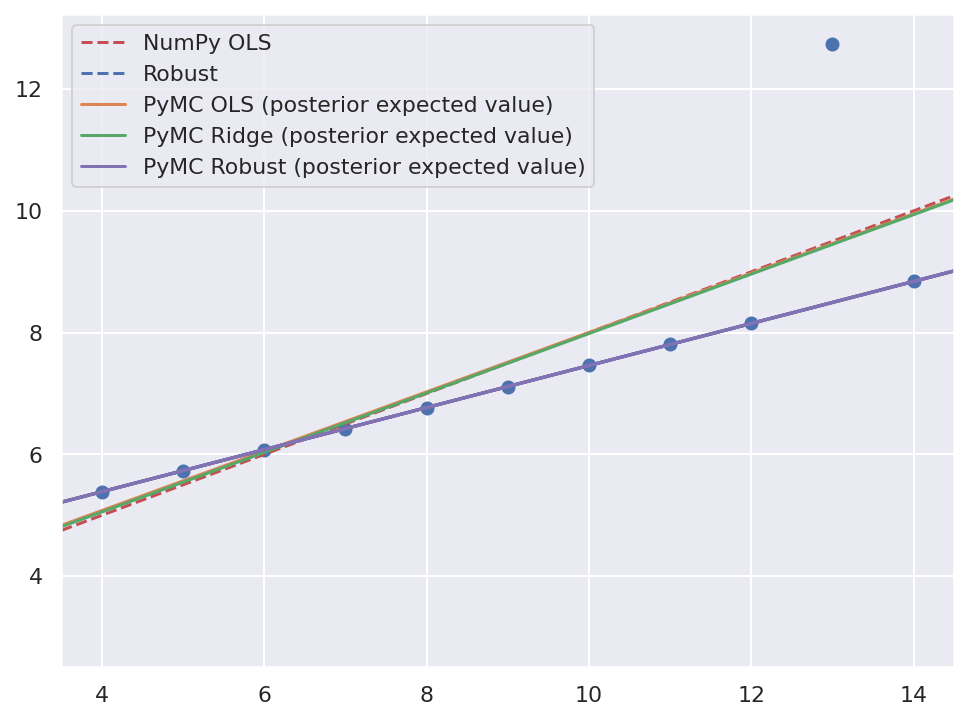

In [56]:
fig, ax = plt.subplots()

ax.scatter(x, y3);
plot_line(m_ols, b_ols, c='r', ls='--', label="NumPy OLS", ax=ax);
plot_line(m_robust, b_robust, c='C0', ls='--', label="Robust", ax=ax);
plot_line(
    ols_trace.posterior["m"].mean(dim=("chain", "draw")),
    ols_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C1', label="PyMC OLS (posterior expected value)", ax=ax
);
plot_line(
    ridge_trace.posterior["m"].mean(dim=("chain", "draw")),
    ridge_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C2', label="PyMC Ridge (posterior expected value)", ax=ax
);

plot_line(
    robust_trace.posterior["m"].mean(dim=("chain", "draw")),
    robust_trace.posterior["b"].mean(dim=("chain", "draw")),
    c='C4', label="PyMC Robust (posterior expected value)", ax=ax
);


for m, b in (robust_trace.posterior[["m", "b"]]
                         .sel(chain=0)
                         .thin(THIN)
                         .to_array().T):
    plot_line(m.values, b.values, c='C4', alpha=0.25, ax=ax);

ax.set_xlim(3.5, 14.5);

ax.legend();

The posterior plots for this model show the true (robust) $m$ and $b$ comfortably in the middle of their high posterior density intervals.

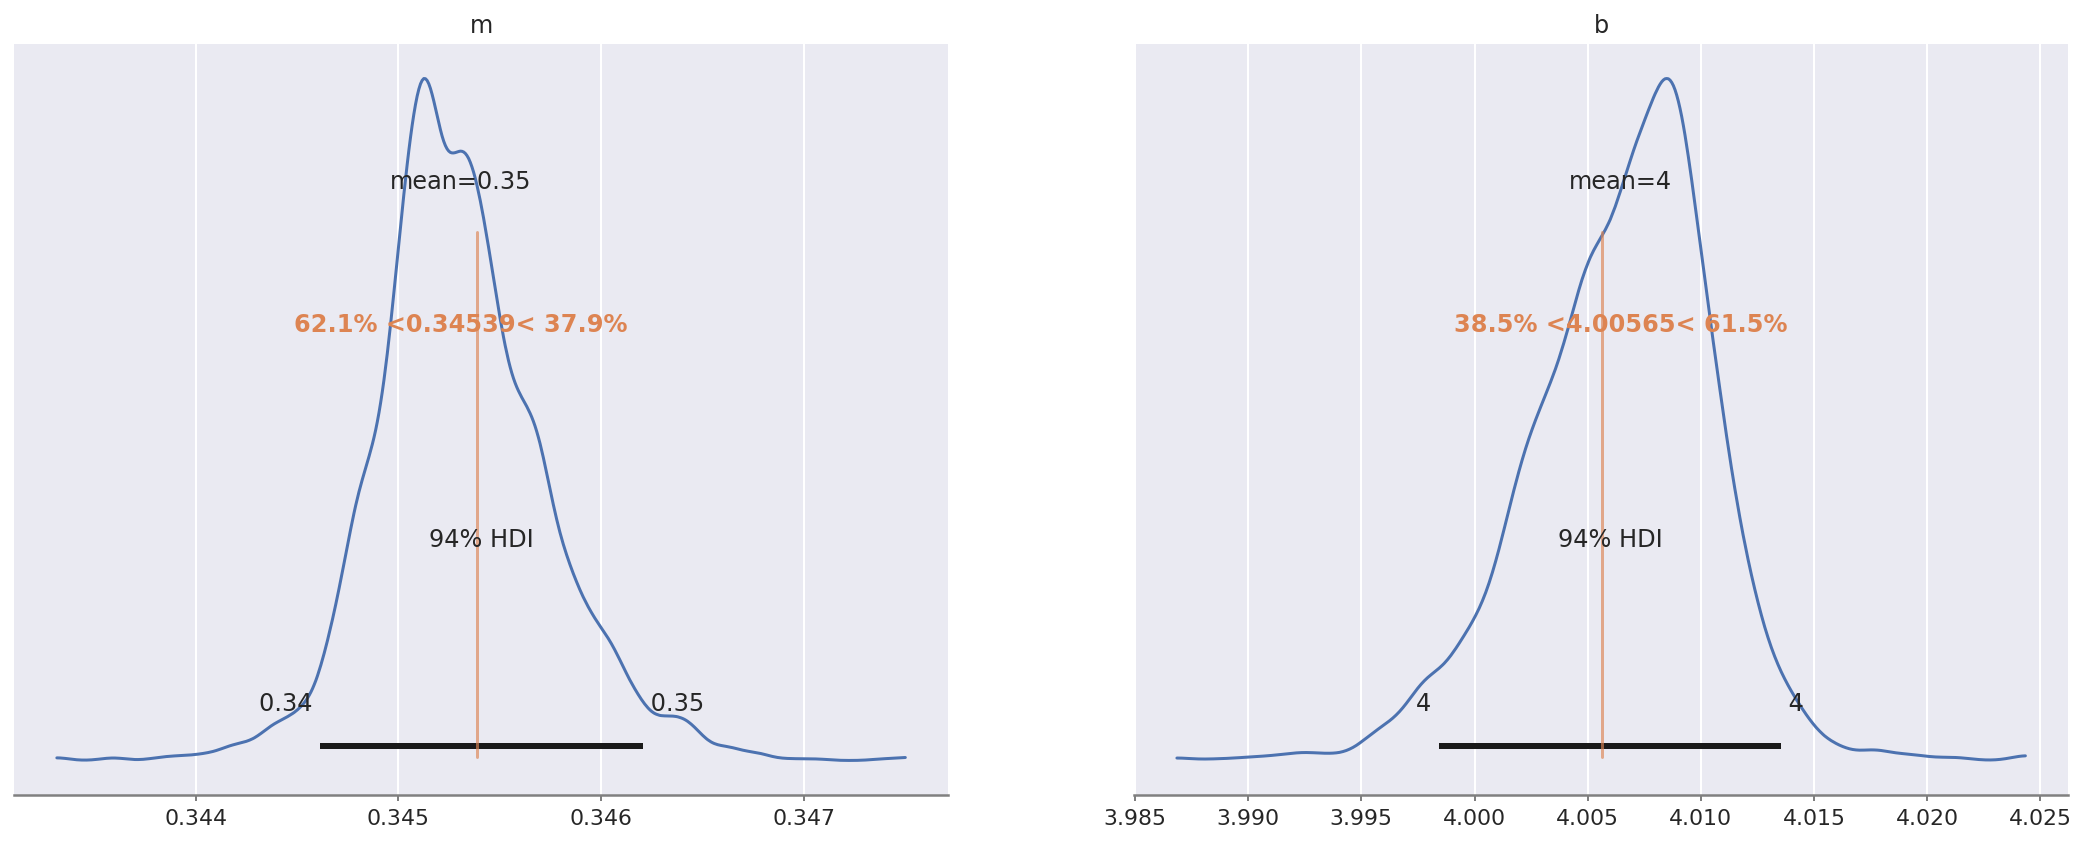

In [57]:
az.plot_posterior(robust_trace, var_names=["m", "b"], ref_val=[m_robust, b_robust]);

Robust regression provides an excellent example of the flexibility of probabilistic programming in PyMC.  By changing the distributions that are the building blocks of our model, we were able to iterate from an OLS model that was quite sensitive to the presence of an outlier to a robust model that completely ignored the outlier.

## A Bayesian analysis of Lego set prices

Now that we have solved the Monty Hall problem and built a robust regression model using PyMC, we turn our attention to a more realistic example.

I am an [AFOL](https://en.wiktionary.org/wiki/AFOL) (adult fan of Lego), part of [my collection](https://brickset.com/sets/ownedby-arochford) is shown below.

![Part of my Lego collection](https://austinrochford.com/resources/lego/IMG_5698.png)

![Another part of my Lego collection](https://austinrochford.com/resources/lego/IMG_5696.png)

My collection is mostly Star Wars and NASA sets, with a few miscellaneous others ([Birds of Paradise (10289)](https://www.lego.com/en-us/product/bird-of-paradise-10289) is a particularly nice set, in my opinion).  I have enjoyed the trend of Lego releasing detailed display sets for adults in recent years, so when the company announced [Darth Vader Meditation Chamber (75296)](https://www.lego.com/en-us/product/darth-vader-meditation-chamber-75296), I was intrigued.

<img alt="Darth Vader Meditation Chamber Lego set (75296)" src="https://www.lego.com/cdn/cs/set/assets/blt234378cdb80fb126/75296.jpg" width=600>

The set contains 663 pieces and was priced at $69.99 in the US, which felt a bit expensive to me.  As a data nerd, I was determined to see how this price compared to other sets historically before I decided whether or not to order it.  The result of this effort was five blog posts:

* [A Fair Price for Darth Vader's Meditation Chamber? A Lego Price Analysis](https://austinrochford.com/posts/2021-06-03-vader-meditation.html)
* [A Bayesian Analysis of Lego Prices in Python with PyMC3](https://austinrochford.com/posts/2021-06-10-lego-pymc3.html)
* [A Fair Price for the Republic Gunship? A Bayesian Analysis of Ultimate Collector Series Prices in Python with PyMC3](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html)
* [A Fair Price for the Titanic? A Bayesian Analysis of the Price of Large Lego Sets](https://austinrochford.com/posts/lego-titanic-large-set-pricing.html)
* [A Bayesian Model of Lego Set Ratings](https://austinrochford.com/posts/lego-ratings-bayes.html)

For the final example of this post we will recreate a simplified version of the PyMC model of Lego set prices developed in these posts.

The data used for this example was scraped from [Brickset](https://brickset.com/), an online reference for Lego enthusiasts.  The data includes mosts sets released between 1980 and the end of 2021, with some light filtering discussed in the above posts.

<img alt="Brickset logo" src="https://images.brickset.com/news/Brickset%20Logo.png" width=700>

We now load the Lego data.

In [58]:
LEGO_DATA_URL = "https://austinrochford.com/resources/talks/data_umbrella_brickset_19800101_20211098.csv"

In [59]:
lego_df = pd.read_csv(LEGO_DATA_URL, parse_dates=["Year released"], index_col="Set number")
lego_df["Year released"] = lego_df["Year released"].dt.year

In [60]:
lego_df

Name Set type       Theme  \
Set number                                                        
1041-2      Educational Duplo Building Set   Normal       Dacta   
1075-1       LEGO People Supplementary Set   Normal       Dacta   
5233-1                             Bedroom   Normal   Homemaker   
6305-1                   Trees and Flowers   Normal        Town   
6306-1                          Road Signs   Normal        Town   
...                                    ...      ...         ...   
80025-1          Sandy's Power Loader Mech   Normal  Monkie Kid   
80026-1                Pigsy's Noodle Tank   Normal  Monkie Kid   
80028-1                     The Bone Demon   Normal  Monkie Kid   
80106-1                      Story of Nian   Normal    Seasonal   
80107-1            Spring Lantern Festival   Normal    Seasonal   

            Year released  Pieces                       Subtheme    RRP$  \
Set number                                                                 
1041-2               1980    68.0                            NaN   36.50   
1075-1               1980   304.0                            NaN   14.50   
5233-1               1980    26.0                            NaN    4.50   
6305-1               1980    12.0                    Accessories    3.75   
6306-1               1980    12.0                    Accessories    2.50   
...                   ...     ...                            ...     ...   
80025-1              2021   520.0                       Season 2   54.99   
80026-1              2021   662.0                       Season 2   59.99   
80028-1              2021  1375.0                       Season 2  119.99   
80106-1              2021  1067.0  Chinese Traditional Festivals   79.99   
80107-1              2021  1793.0  Chinese Traditional Festivals  119.99   

               RRP2021  
Set number              
1041-2      122.721632  
1075-1       48.752429  
5233-1       15.130064  
6305-1       12.608387  
6306-1        8.405591  
...                ...  
80025-1      54.990000  
80026-1      59.990000  
80028-1     119.990000  
80106-1      79.990000  
80107-1     119.990000  

[6423 rows x 8 columns]

Most of the columns of this data frame are self-explanatory.  `RRP` is "recommended retail price," it is the price Lego charges for the set through [Lego.com](https://www.lego.com/) and its [brick-and-mortar retail stores](https://www.lego.com/en-us/stores).  `RRP2021` is this recommended retail price adjusted to 2021 dollars.  (For details about adjustment, see [this post](https://austinrochford.com/posts/2021-06-03-vader-meditation.html).)

### Exploratory data analysis

Naturally sets with more pieces will cost more, which we confirm by visualizing the relationship between `Pieces` and `RRP2021`.

In [61]:
VADER_MEDITATION = "75296-1"

vader_label = f"{lego_df.loc[VADER_MEDITATION, 'Name']} ({VADER_MEDITATION.split('-')[0]})"

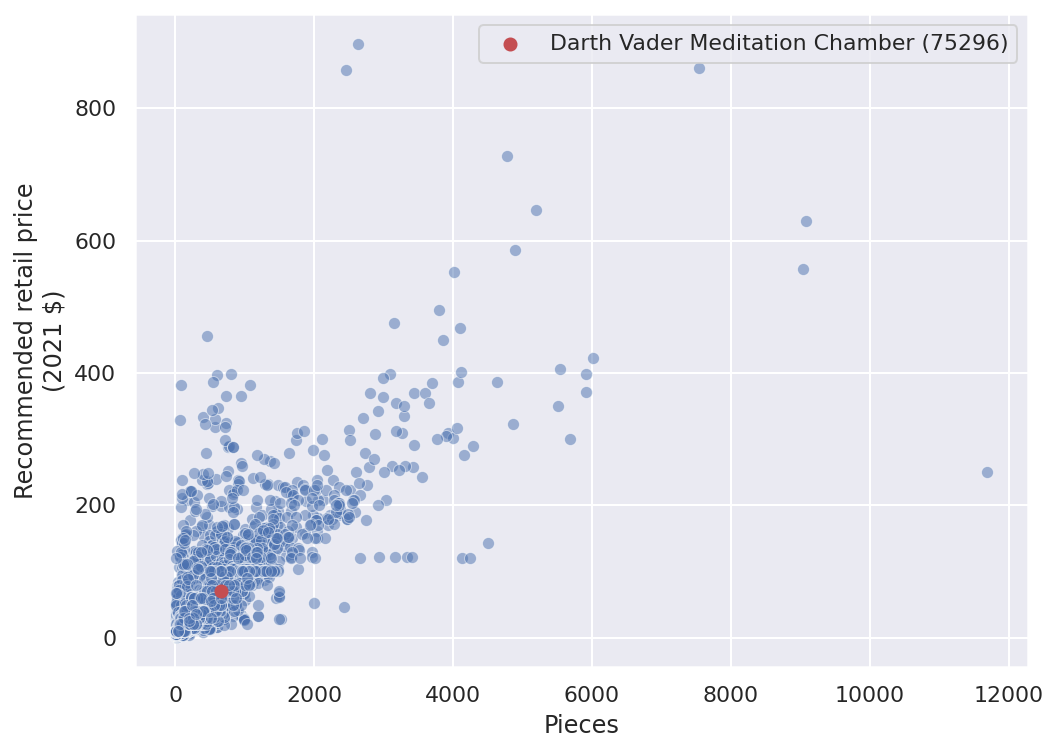

In [62]:
ax = sns.scatterplot(x="Pieces", y="RRP2021", data=lego_df,
                     alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Pieces"],
           lego_df.loc[VADER_MEDITATION, "RRP2021"],
           c='r', label=vader_label);

ax.set_ylabel("Recommended retail price\n(2021 $)");
ax.legend();

Since the number of pieces in a set and the corresponding prices vary widely, we log-transform both below.

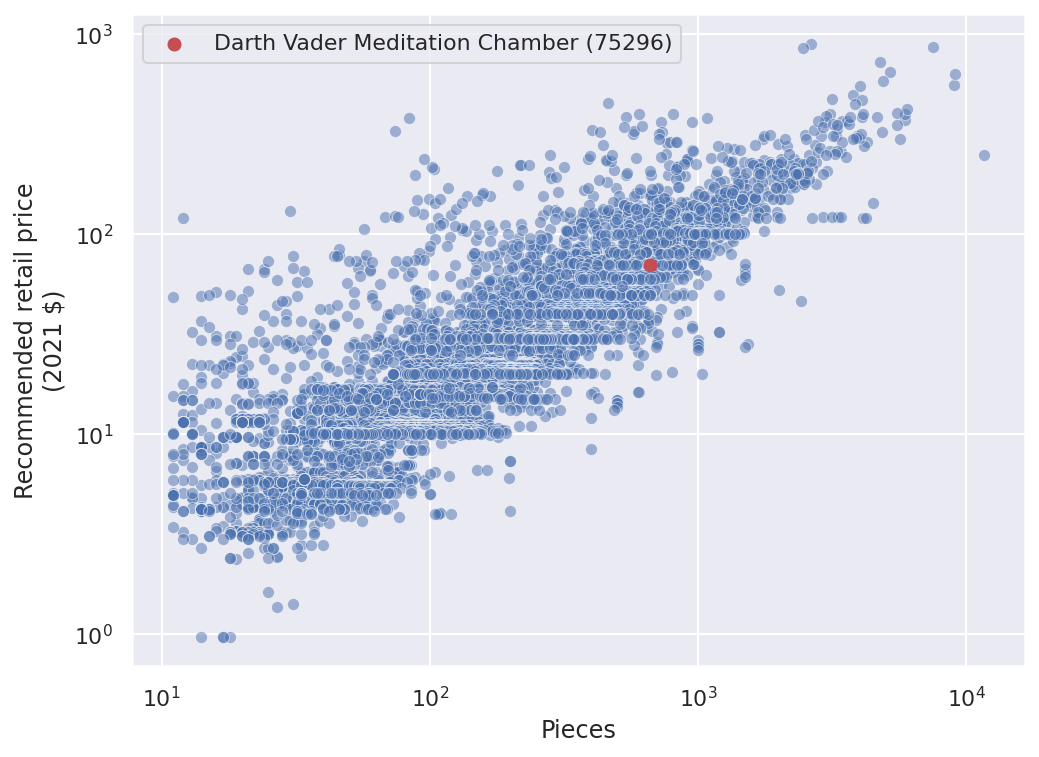

In [63]:
ax = sns.scatterplot(x="Pieces", y="RRP2021", data=lego_df,
                     alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Pieces"],
           lego_df.loc[VADER_MEDITATION, "RRP2021"],
           c='r', label=vader_label);

ax.set_xscale('log');

ax.set_yscale('log');
ax.set_ylabel("Recommended retail price\n(2021 $)");

ax.legend();

These plots also highlights the location of Darth Vader Meditation Chamber (75296). It's difficult to tell whether or not the set is fairly priced for its size, hence the need for a statistical model.

Another consideration is that Lego likely has improved their manufacturing processes over time, reducing the average price it costs to produce a piece.  An interesting question is whether or not some of these presumed savings have been passed onto the consumer, or if Lego has chosen to retain them all as increased margin.

Below we visualize how the log price per log piece has changed over time since 1980.  (`LLPPP2021` stands for log-log price per piece in 2021 dollars, which is a mouthful, so we will try not to spell it out too often.)

In [64]:
lego_df["LLPPP2021"] = (
    lego_df["RRP2021"]
           .pipe(np.log)
           .div(lego_df["Pieces"]
                       .pipe(np.log))
)

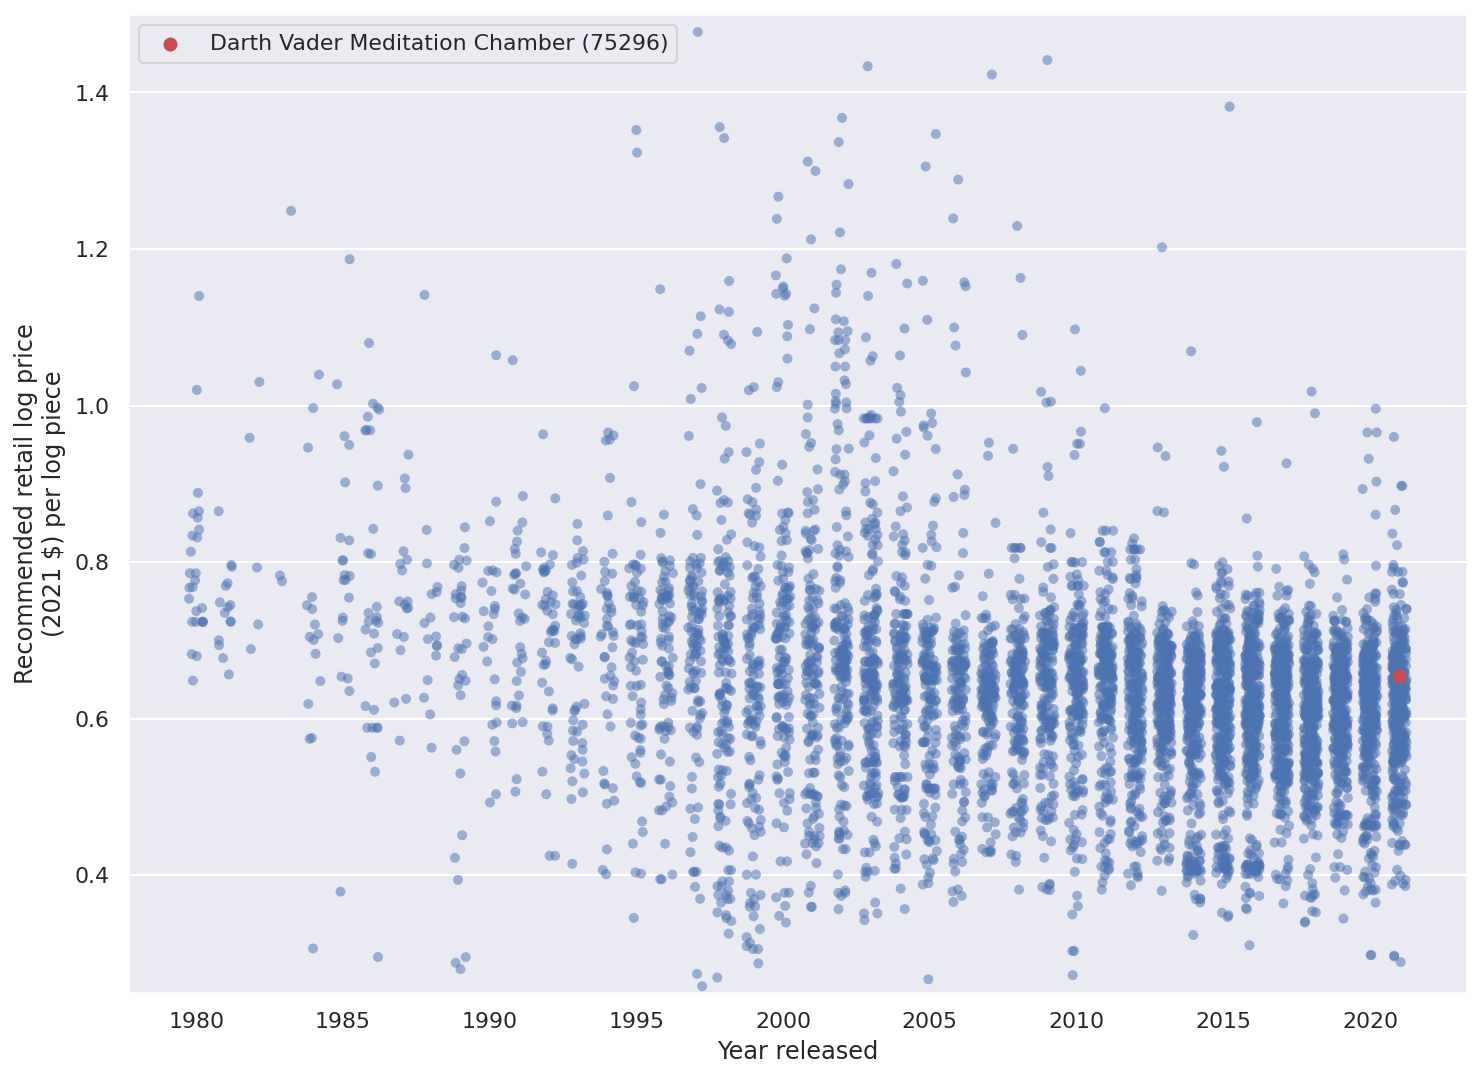

In [65]:
fig, ax = plt.subplots(figsize=1.5 * FIG_SIZE)

sns.stripplot(x="Year released", y="LLPPP2021", data=lego_df,
              jitter=0.25, color='C0', alpha=0.5, ax=ax)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Year released"] - lego_df["Year released"].min(),
           lego_df.loc[VADER_MEDITATION, "LLPPP2021"],
           c='r', zorder=10, label=vader_label);

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_ylim(0.25, 1.5);
ax.set_ylabel("Recommended retail log price\n(2021 $) per log piece");

ax.legend();

It certainly appears that the (log) price Lego charges per (log) piece has decreased over time.  Darth Vader Meditation Chamber (75296) seems to be a bit above average in this respect for sets released in 2021.

Another factor likely to influence the price of a set is its theme.  It seems plausible that themes primarily targeted at children might have a slightly smaller cost per piece than those targeted at adults, and that themes that involve licensed intellectual property (Star Wars, Disney, Marvel, etc.) would have a higher price per piece to maintain Lego's margins while covering licensing costs.

In [66]:
PLOT_THEMES = ["Star Wars", "Disney", "Marvel Super Heroes", "Creator", "City", "Friends"]

lego_df["Plot theme"] = (lego_df["Theme"]
                                .where(lego_df["Theme"].isin(PLOT_THEMES),
                                       "Other"))
theme_plot_min_year = (lego_df[lego_df["Theme"].isin(PLOT_THEMES)]
                             ["Year released"]
                             .sub(1)
                             .min())

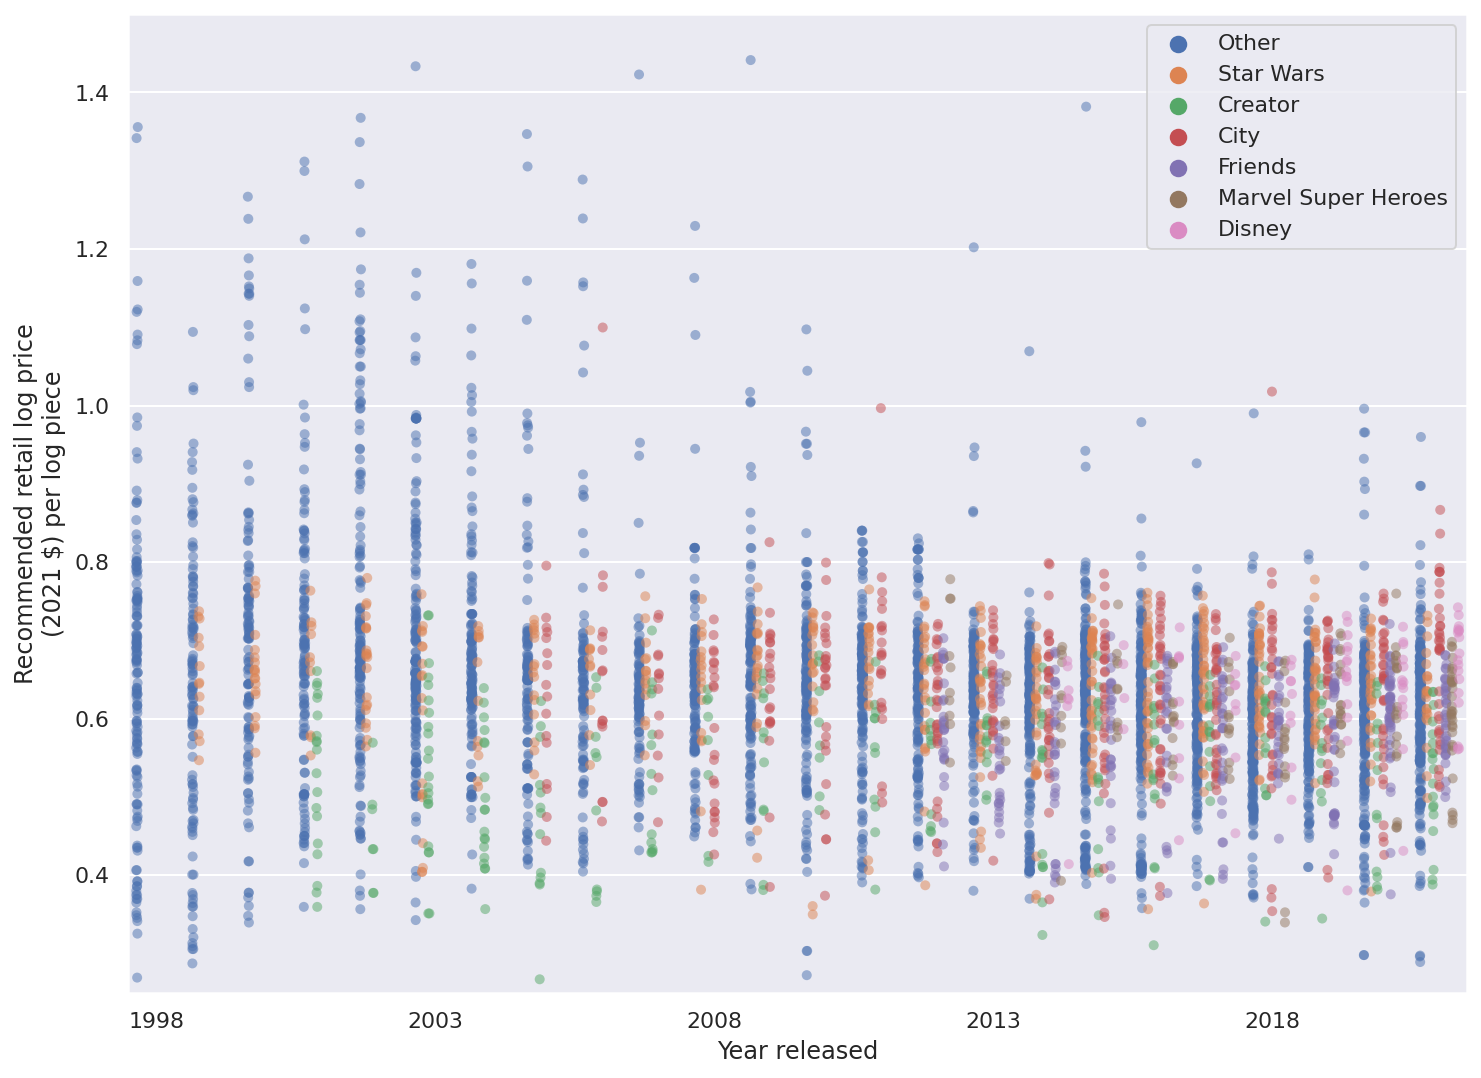

In [67]:
fig, ax = plt.subplots(figsize=1.5 * FIG_SIZE)

sns.stripplot(
    x="Year released", y="LLPPP2021", hue="Plot theme",
    data=lego_df[lego_df["Year released"] >= theme_plot_min_year],
    dodge=True, alpha=0.5, ax=ax
);

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_ylim(0.25, 1.5);
ax.set_ylabel("Recommended retail log price\n(2021 $) per log piece");

ax.legend();

The above plot shows that this narrative is plausible but not obviously correct, so we will use our model to evaluate it further.

### Price model

The exploratory data analysis above has highlighted three factors that we would like to include in our model:

1. the log-log relationship between piece count and price,
2. the decreasing log price per log piece over time, and
3. these relationships vary by theme.

With these factors in mind, our model takes the following general form.

$$\log \text{Price} \approx (\text{Year intercept}) + (\text{Theme intercept}) + \left((\text{Year slope}) + (\text{Theme slope})\right) \cdot \log \text{Pieces}$$

There are many ways we could choose to encode the time-varying and theme-varying components of this model.  For simplicity in this introductory post we model the time-varying components as [Gaussian random walks](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) and the theme-varying components as [hierarchical normal distributions](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/).

In [68]:
def gaussian_random_walk(name, *, dims, innov_scale=1.):
    Δ = pm.Normal(f"Δ_{name}", 0., innov_scale,  dims=dims)

    return pm.Deterministic(name, Δ.cumsum(), dims=dims)

def noncentered_normal(name, *, dims, μ=None):
    μ = pm.Normal(f"μ_{name}", 0., 2.5)
    Δ = pm.Normal(f"Δ_{name}", 0., 1., dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5)
    
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

We will not dwell on the mathematical details of these components in this post, instead providing links to further reading above. What is important about these components is that they are relatively simple combinations of our model building blocks, PyMC distributions.

We now do some very light feature engineering ([standardizing](https://en.wikipedia.org/wiki/Standard_score) the log piece count, [encoding themes numerically](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html), transforming `Year released` to number of years after 1980, etc.).

In [69]:
log_pieces = (lego_df["Pieces"]
                     .pipe(np.log)
                     .values)

scaler = StandardScaler().fit(log_pieces[:, np.newaxis])

def scale_log_pieces(log_pieces, scaler=scaler):
    return scaler.transform(log_pieces[:, np.newaxis])[:, 0]

std_log_pieces = scale_log_pieces(log_pieces)

In [70]:
log_rrp2021 = (lego_df["RRP2021"]
                      .pipe(np.log)
                      .values)

In [71]:
theme_id, theme_map = lego_df["Theme"].factorize(sort=True)

In [72]:
t, years = lego_df["Year released"].factorize(sort=True)

We are now ready to specify our model.  First we define the [coordinates xarray will use](https://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray-coordinates) to label our results.  These coordinates allow ArviZ to produce semantically meaningful visualizations of the posterior distribution.  For more detailed information about how PyMC and ArviZ benefit from using xarray coordinates, see this [excellent post](https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html) from PyMC and ArviZ contributor [Oriol Abril](https://oriolabril.github.io/oriol_unraveled/about/).

In [73]:
coords = {
    "set": lego_df.index,
    "theme": theme_map,
    "year": years
}

We first define the time- and theme-varying components of the intercept.  The `coords` argument passed to the model's constructor tells PyMC and ArviZ how to label the results of inference.

In [74]:
with pm.Model(coords=coords, rng_seeder=SEED) as lego_model:
    β0_t = gaussian_random_walk("β0_t", dims="year", innov_scale=0.1)
    β0_theme = noncentered_normal("β0_theme", dims="theme")

Similarly we define the time- and theme-varying components of the price-per-log piece.

In [75]:
with lego_model:
    β_pieces_t = gaussian_random_walk("β_pieces_t", dims="year", innov_scale=0.1)
    β_pieces_theme = noncentered_normal("β_pieces_theme", dims="theme")

We now define the scale of the observational noise and the predicted log price of each set.

In [76]:
with lego_model:
    σ = pm.HalfNormal("σ", 5.)
    μ = β0_t[t] + β0_theme[theme_id] \
        + (β_pieces_t[t] + β_pieces_theme[theme_id]) * std_log_pieces \
        - 0.5 * σ**2

The term `- 0.5 * σ**2` in the definiton of `μ` comes from the fact that this linear model of log price in terms of log piece count is equivalent to a multiplicative model of price in terms of piece count.  (See [this post](https://austinrochford.com/posts/2021-05-17-tyrannosaurid-pymc3.html) for details.)

Finally we specify the likelihood of the observed log prices.

In [77]:
with lego_model:
    obs = pm.Normal("obs", μ, σ, dims="set", observed=log_rrp2021)

#### Why Hamiltonian Monte Carlo?

To illustrate the power of the Hamiltonian Monte carlo inference algorithms that PyMC uses Aesara to implement, we first perform inference on this model using the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).  Metropolis-Hastings is a relatively simple Markov chain Monte Carlo method that does not use gradient information to account for the shape of the posterior distribution.  We choose this sampler by specifying `step=pm.Metropolis()`.

In [78]:
with lego_model:
    mh_trace = pm.sample(**SAMPLE_KWARGS, step=pm.Metropolis(), draws=10_000)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [Δ_β0_t]
>Metropolis: [μ_β0_theme]
>Metropolis: [Δ_β0_theme]
>Metropolis: [σ_β0_theme]
>Metropolis: [Δ_β_pieces_t]
>Metropolis: [μ_β_pieces_theme]
>Metropolis: [Δ_β_pieces_theme]
>Metropolis: [σ_β_pieces_theme]
>Metropolis: [σ]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 75 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


PyMC and ArviZ warn us that this sampler has not converged.  Indeed, when we visualize the [$\hat{R}$ statistics](https://mc-stan.org/) for the resulting samples we see that they are significantly larger than one.

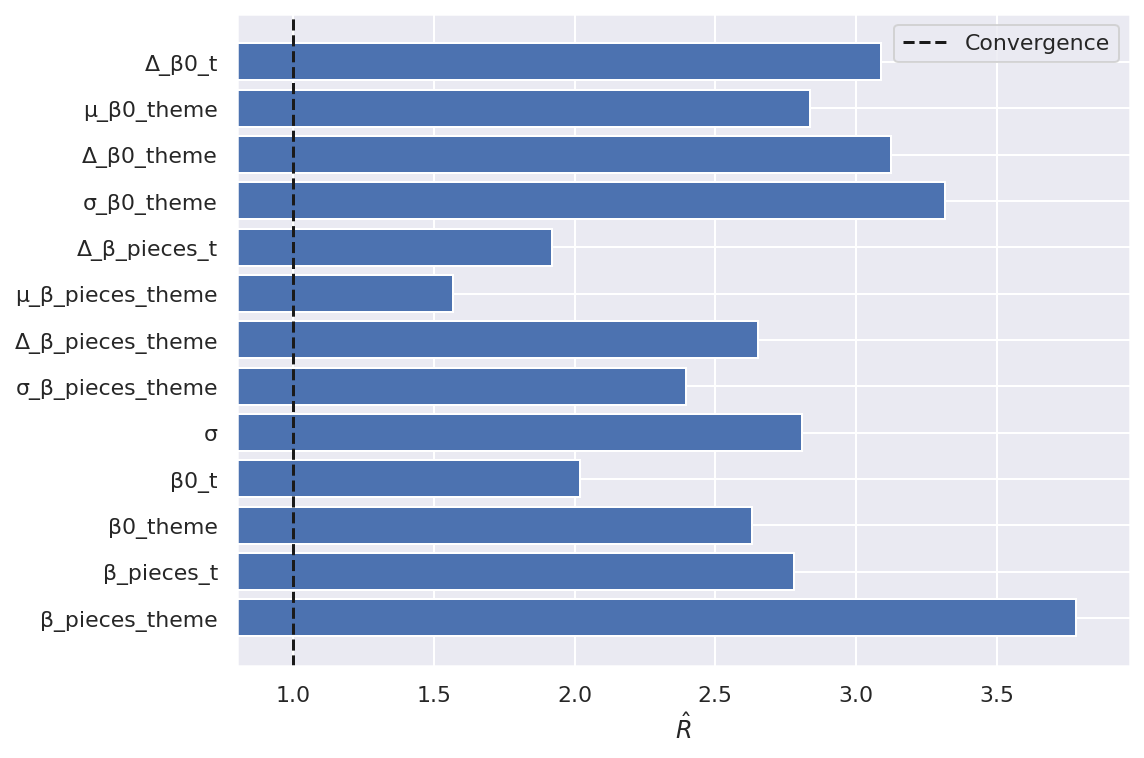

In [79]:
fig, ax = plt.subplots()

max_rhat = (az.rhat(mh_trace)
               .max()
               .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(left=0.8);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();

Since convergent samples should have $\hat{R}$ statistics quite close to one, we do not trust these results.  To further reinforce this point, we plot the densities and trajectories of the samples for $\sigma$ from each of the three chains below.

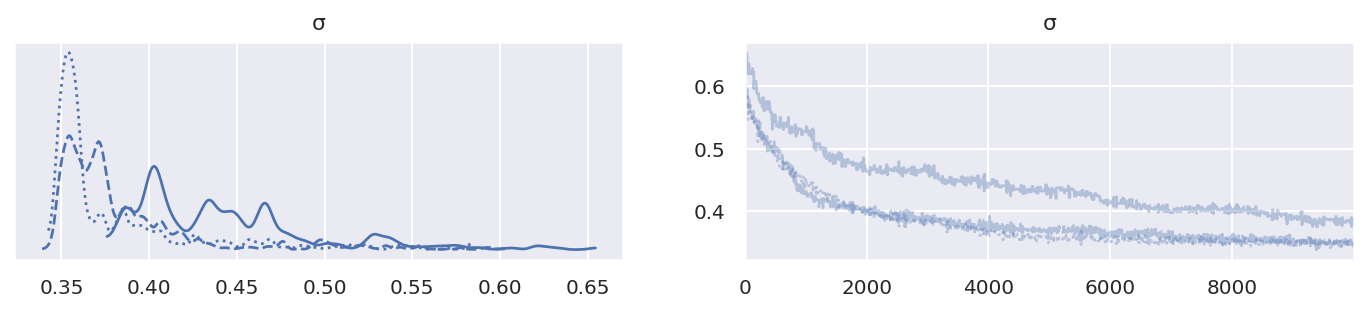

In [80]:
az.plot_trace(mh_trace, var_names="σ");

The complex, multimodal distributions on the left and the noticeably different between chain trajectories on the right are symptomatic of sampling issues.  It is these symptoms that are quantified in the $\hat{R}$ statistic for $\sigma$.  For more information on $\hat{R}$ statistics, consult the excellent paper [_Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_](https://arxiv.org/abs/1903.08008).

When we considered in the context of the curse of dimensionality these convergence issues are not surprising.  This model has

In [81]:
n_lego_param = sum([
    coords["year"].size,  # time intercept increments
    coords["theme"].size, # theme intercept offsets
    2,                    # theme intercept location and scale
    coords["year"].size,  # time slope increments
    coords["theme"].size, # theme slope offsets
    2,                    # theme intercept location and scale
    1                     # scale of observational noise
])

In [82]:
n_lego_param

351

parameters.  Since the volume of the unit sphere in 351-dimensional space is quite small, the Metropolis-Hastings sampler struggles to approximate this model's posterior distribution well.

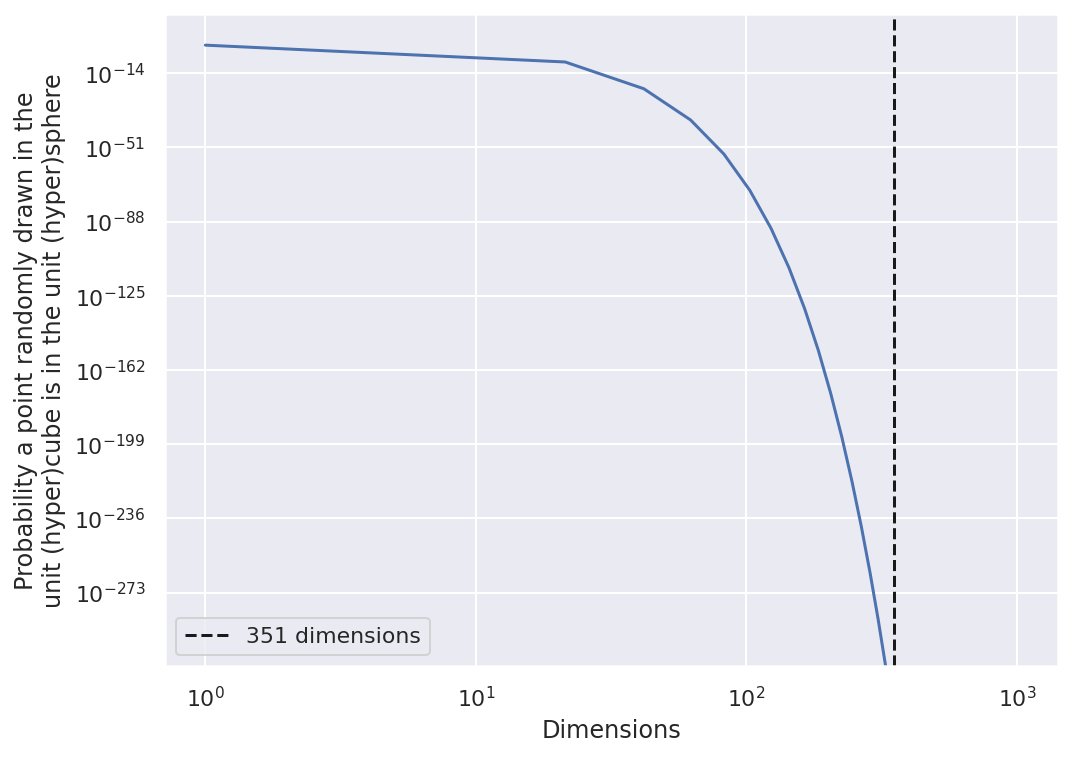

In [83]:
cod_ax.axvline(n_lego_param, c='k', ls='--', label=f"{n_lego_param} dimensions");
cod_ax.legend();

cod_fig

We now sample from the posterior distribution of this model using adaptive HMC (NUTS).

In [84]:
with lego_model:
    lego_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Δ_β0_t, μ_β0_theme, Δ_β0_theme, σ_β0_theme, Δ_β_pieces_t, μ_β_pieces_theme, Δ_β_pieces_theme, σ_β_pieces_theme, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 610 seconds.
The number of effective samples is smaller than 10% for some parameters.


There are no $\hat{R}$ warnings here, only a rather mild warning about the number of effective samples.  We see below that the $\hat{R}$ statistics are quite close to one, indicating no obvious issues with convergence.

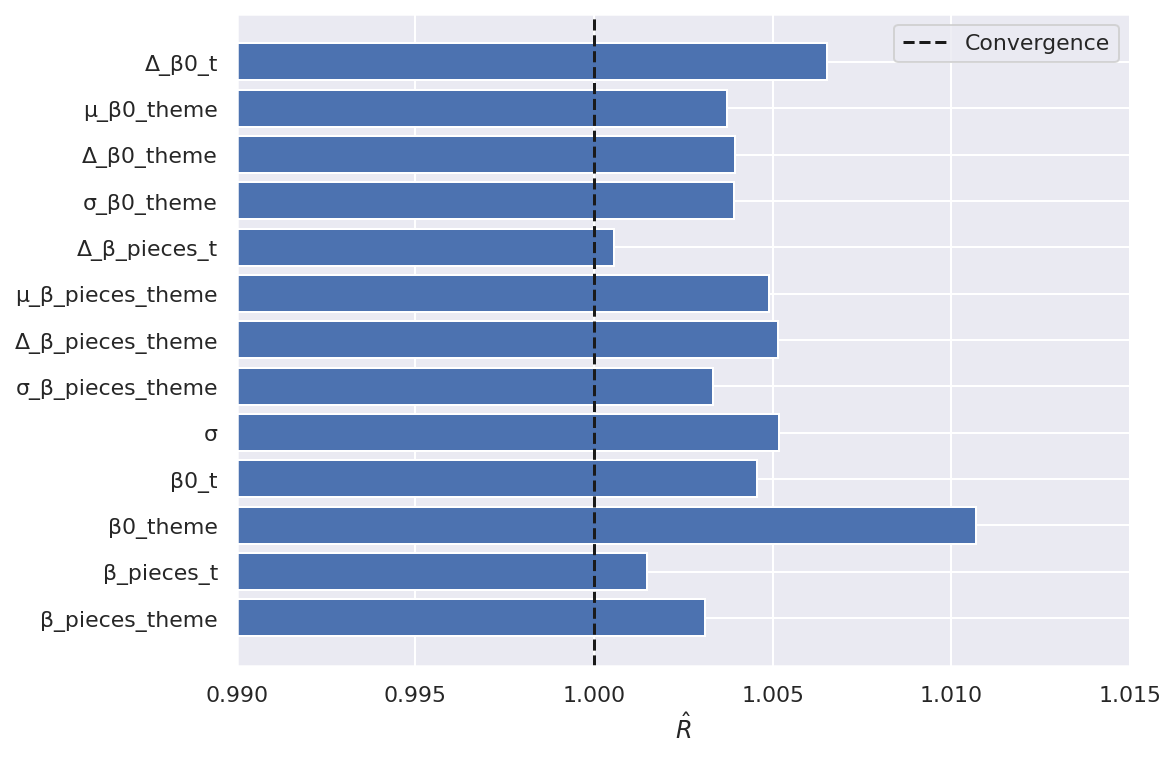

In [85]:
fig, ax = plt.subplots()

max_rhat = (az.rhat(lego_trace)
               .max()
               .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(0.99, 1.015);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();

The per-chain posterior distributions of $\sigma$ and look reasonable for these samples, and the chain trajectories appear well-mixed.

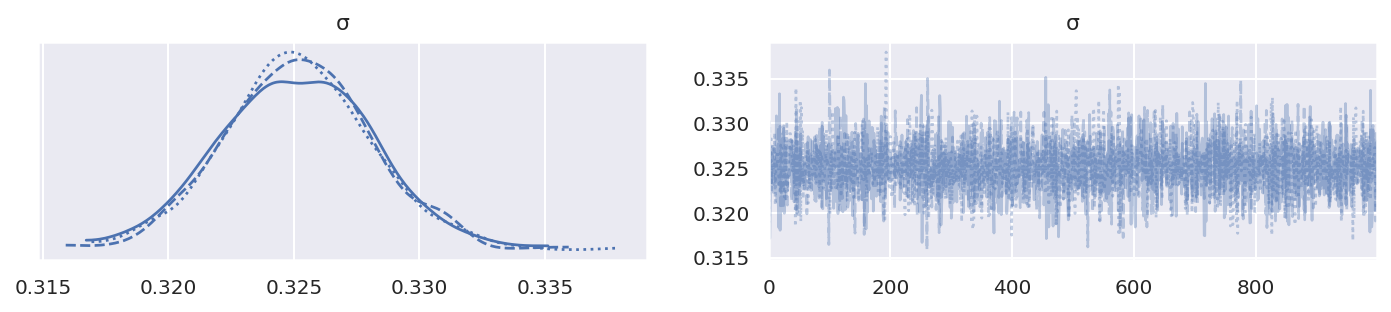

In [86]:
az.plot_trace(lego_trace, var_names="σ");

Judging only by the sampling (clock) time, we might be tempted to prefer inference with Metropolis-Hastings sampling, as it takes significantly less time than with adaptive HMC sampling.

In [87]:
sampling_time = np.array([
    mh_trace.sample_stats.sampling_time,
    lego_trace.sample_stats.sampling_time
])

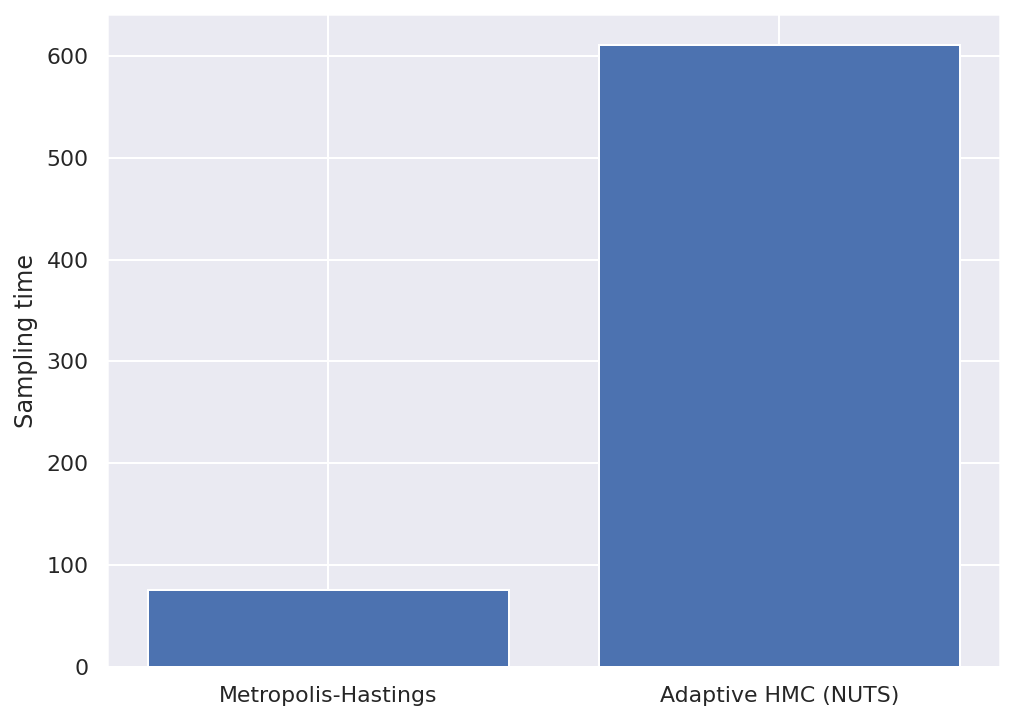

In [88]:
fig, ax = plt.subplots()

ax.bar([0, 1], sampling_time);

ax.set_xticks([0, 1]);
ax.set_xticklabels(["Metropolis-Hastings", "Adaptive HMC (NUTS)"]);

ax.set_ylabel("Sampling time");

This speed is, however, deceptive.  In Markov chain Monte Carlo inference it important to consider the [_effective_ sample size](https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html), which takes into account the quality of each sample. Effective sample size is intimately connected to the $\hat{R}$ statistic we checked above.  Below we plot the sampling rate in terms of effective samples per second for $\sigma$ (the conclusion is similar for the other parameters).

In [89]:
σ_ess = np.array([
    az.ess(mh_trace, var_names="σ")["σ"],
    az.ess(lego_trace, var_names="σ")["σ"]
])

σ_esps = σ_ess / sampling_time

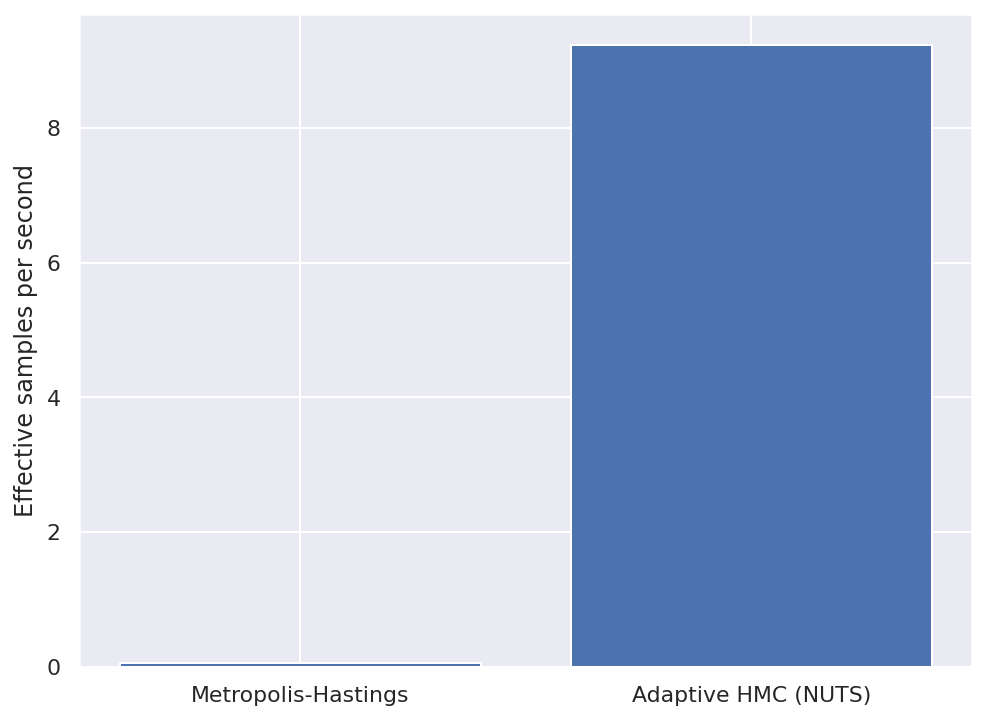

In [90]:
fig, ax = plt.subplots()

ax.bar([0, 1], σ_esps);

ax.set_xticks([0, 1]);
ax.set_xticklabels(["Metropolis-Hastings", "Adaptive HMC (NUTS)"]);

ax.set_ylabel("Effective samples per second");

We see that despite being much slower according to wall-clock time, adaptive HMC is significantly more efficient in terms of effective samples per second.

Under some extremely generous assumptions it would take the Metropolis-Hastings sampler approximately

In [91]:
σ_ess[1] / σ_esps[0] // 60 // 60

28.0

hours to produce the same effective sample size (for $\sigma$) as the adaptive HMC sampler has achieved in about ten minutes.

The vastly superior sampling efficiency of adaptive HMC is well worth the small amount of extra work involved in building our model from Aesara tensor operations.

In these days of billion-parameter neural networks, even this 351-parameter model seems rather tame.  No matter what probabilistic programming language is used, adaptive HMC is crucial to scaling Bayesian inference to modern, complex models of subtle phenomena.

#### Darth Vader Meditation Chamber revisited

We now return to the question that prompted us to build this model: is Darth Vader Meditation Chamber (75296) fairly priced?  To answer this question, we sample from the model's [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution).

In [92]:
with lego_model:
    pp_trace = pm.sample_posterior_predictive(lego_trace)

These posterior predictive samples gives us a distribution of plausible prices for a set with the characteristics of Darth Vader Meditation Chamber (75296).

In [93]:
def format_posterior_artist(artist, formatter):
    text = artist.get_text()
    x, _ = artist.get_position()

    if text.startswith(" ") or text.endswith(" "):
        fmtd_text = formatter(x)
        artist.set_text(
            " " + fmtd_text if text.startswith(" ") else fmtd_text + " "
        )
    elif "=" in text:
        before, _ = text.split("=")
        artist.set_text("=".join((before, formatter(x))))
    elif "<" in text:
        below, ref_val_str, above = text.split("<")
        artist.set_text("<".join((
            below,
            " " + formatter(float(ref_val_str)) + " ",
            above
        )))

def format_posterior_text(formatter, ax=None):
    if ax is None:
        ax = plt.gca()
    
    artists = [artist for artist in ax.get_children() if isinstance(artist, plt.Text)]
    
    for artist in artists:
        format_posterior_artist(artist, formatter)

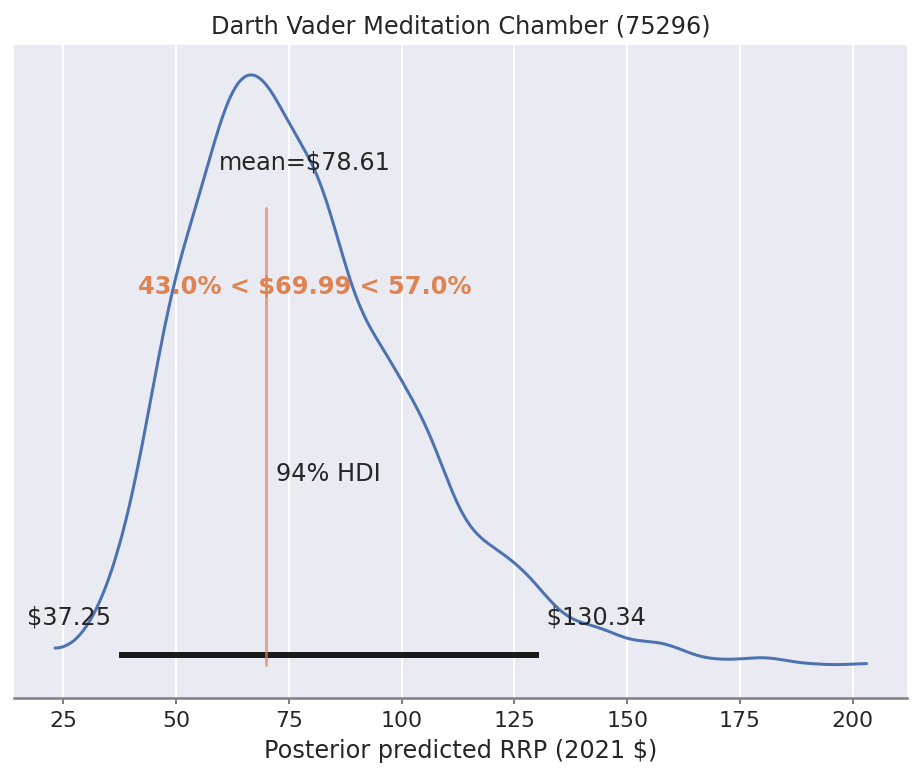

In [94]:
ax = az.plot_posterior(
    pp_trace, group='posterior_predictive', coords={"set": VADER_MEDITATION},
    transform=np.exp, ref_val=lego_df.loc[VADER_MEDITATION, "RRP2021"]
)

format_posterior_text(dollar_formatter, ax=ax);

ax.set_xlabel("Posterior predicted RRP (2021 $)");
ax.set_title(vader_label);

Using `plot_posterior` with just a few more keyword arguments than before, we see that the recommended retail price of $69.99 is comfortably in the middle of the posterior predictive distribution of this set's price.  After seeing this result, I promptly begged my Lego overlords for forgiveness, ordered the set for myself, and can wholeheardetly recommend it to any Star Wars Lego fans.

![Darth Vader Meditation Chamber (75296)|](https://austinrochford.com/resources/lego/75296.png)

Here we have also taken advantage of the fact that `pp_trace.posterior_predictive` is an xarray `Dataset`, so by passing `coords={"set": VADER_MEDITATION}` to `plot_posterior` ArviZ knows to only plot the posterior predictive distribution for Darth Vader Meditation Chamber (75296).  The decal of Admril Ozzel and Captain Piett is a very nice touch.

The following plots show how straightforward it is to use ArviZ to visualize whether the themes we highlighted during EDA have a higher or lower than average baseline price and whether the price increases more or less quickly than average as the number of pieces increases.

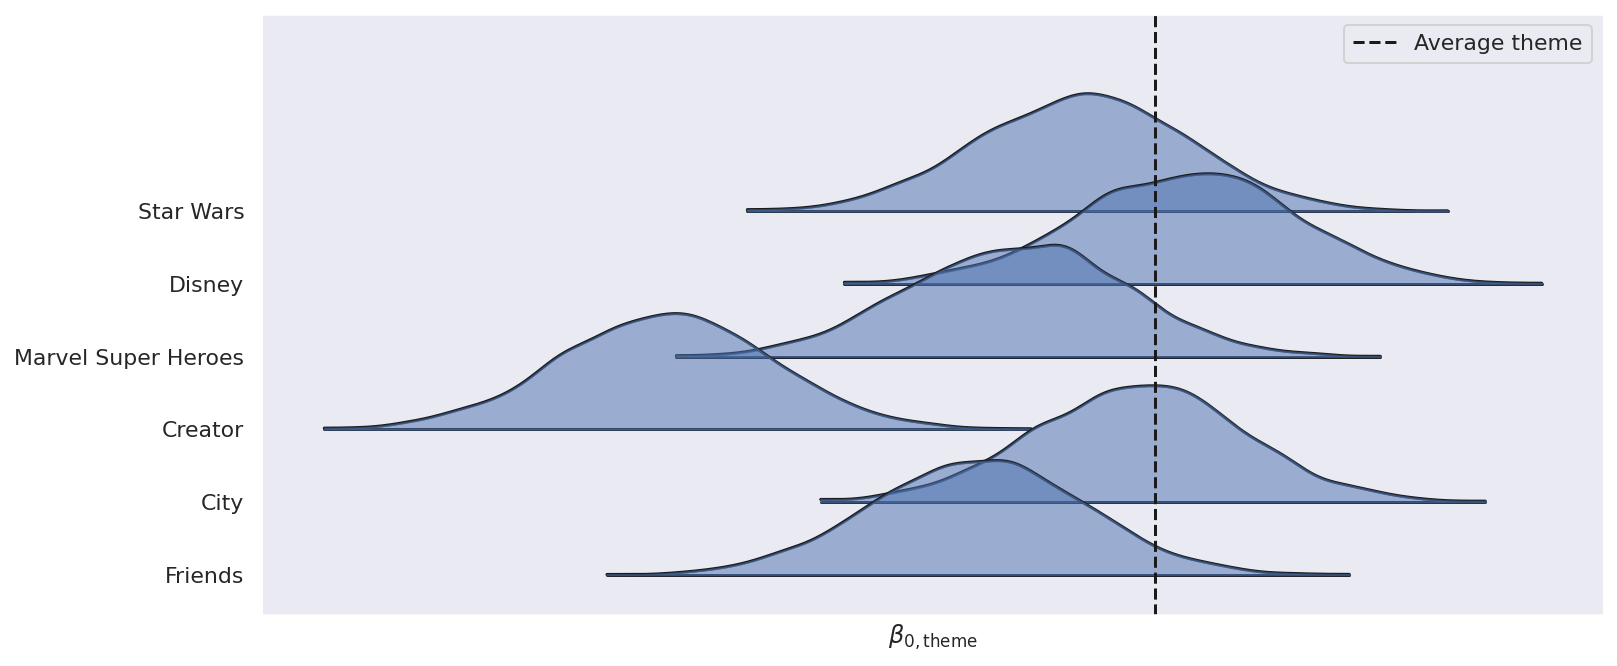

In [95]:
ax, = az.plot_forest(
    lego_trace, var_names="β0_theme",
    coords={"theme": PLOT_THEMES},
    kind='ridgeplot', ridgeplot_alpha=0.5,
    combined=True, hdi_prob=1
)

ax.axvline(
    lego_trace.posterior["μ_β0_theme"].mean(),
    c='k', ls='--', label="Average theme"
);

ax.set_xticks([]);
ax.set_xlabel(r"$\beta_{0, \mathrm{theme}}$");

ax.set_yticklabels(PLOT_THEMES[::-1]);

ax.legend();

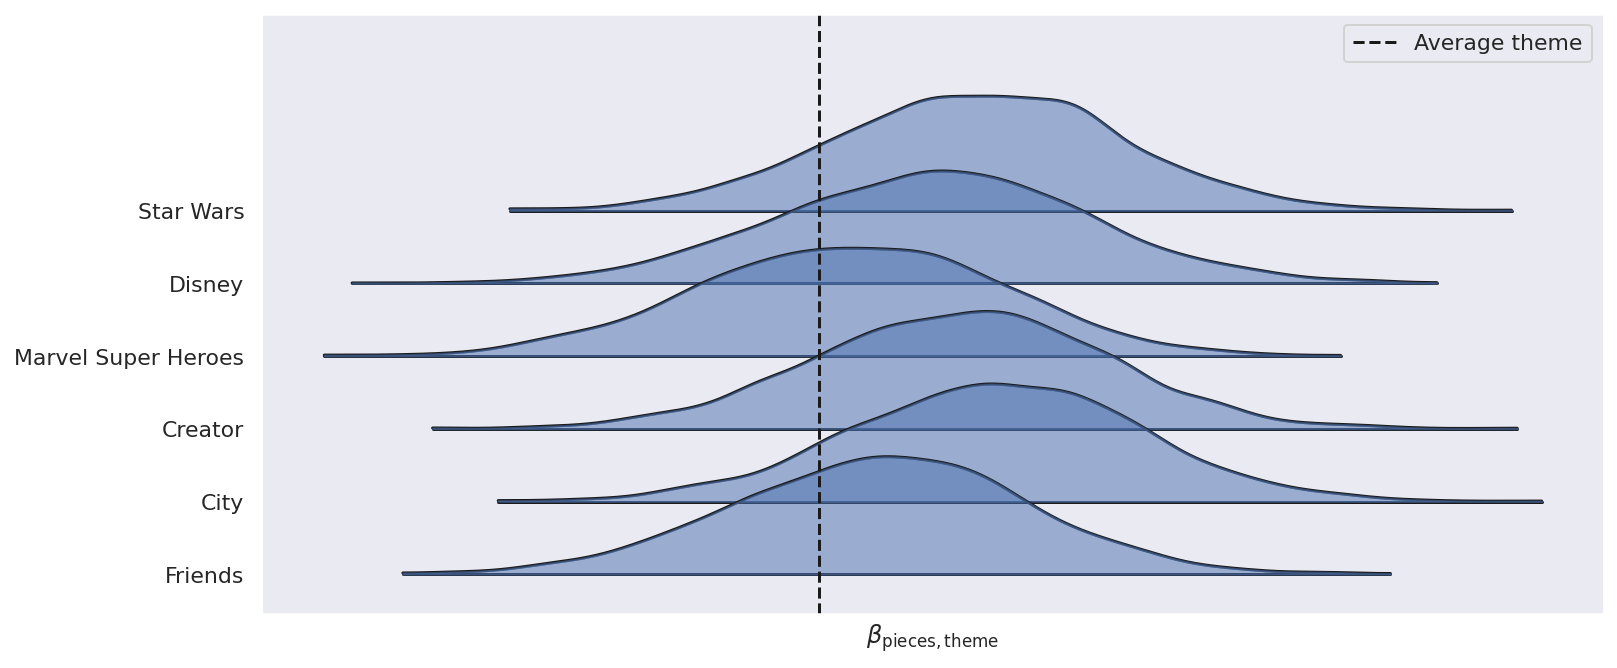

In [96]:
ax, = az.plot_forest(
    lego_trace, var_names="β_pieces_theme",
    coords={"theme": PLOT_THEMES},
    kind='ridgeplot', ridgeplot_alpha=0.5,
    combined=True, hdi_prob=1
)

ax.axvline(
    lego_trace.posterior["μ_β_pieces_theme"].mean(),
    c='k', ls='--', label="Average theme"
);

ax.set_xticks([]);
ax.set_xlabel(r"$\beta_{\mathrm{pieces}, \mathrm{theme}}$");

ax.set_yticklabels(PLOT_THEMES[::-1]);

ax.legend();

## Resources

This post has presented how I think about probabilistic programming, from theoretical principles, to toy problems, to realistic applications.  My perspective is certainly not the only one and probably not the best one (if such a thing exists), but I certainly find it compelling.  If this introduction has sparked your interest in probabilistic programming with PyMC, here are some resources I recommend to learn more.

### References

![Probabilistic Programming and Bayesian Methods for Hackers cover](https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31)

[_Probabilistic Programming and Bayesian Methods for Hackers_](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3) is an excellent open-source introduction to probabilistic programming and Bayesian statistics targeted at those coming from a programming background.  Each chapter is executable as a Jupyter notebook, so readers can modify and extend the examples while learning.  This book introduced me to probabilistic programming almost ten years ago, so I am quite fond of it.  Note that the notebooks currently use PyMC3, the previous version of PyMC, while this introduction has used PyMC v4.  The code will run under PyMC v4 with at most very slight modifications.

<img alt="Bayesian Modeling and Computation in Python cover" src="https://bayesiancomputationbook.com/_images/Cover.jpg" width=400>

[_Bayesian Modeling and Computation in Python_](https://bayesiancomputationbook.com/welcome.html) is an excellent recently released book by Osvaldo A. Martin, Ravin Kumar, and Junpeng Lao.  All three of the authors are [core contributors](https://github.com/pymc-devs/pymc/blob/main/GOVERNANCE.md#current-core-contributors) to PyMC.  They have generously released the contents of the book for free at the above link, but please consider supporting their excellent work by purchasing a copy if you can afford to do so.  The same caveat applies in that this book targets PyMC3.

![Statistical Rethinking: A Bayesian Course with Examples in R and Stan cover](http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg)

[_Statistical Rethinking: A Bayesian Course with Examples in R and Stan_](https://xcelab.net/rm/statistical-rethinking/) is an excellent book by Richard McElreath targeted at those coming from a social science background.  Though it presents its examples in R using the [Stan](https://mc-stan.org/) probabilistic programming language, it is nonetheless an excellent introduction to Bayesian thinking and model building.  Because the book's content is so good, a number of PyMC enthusiasts have [ported the examples and solved the exercises](https://github.com/pymc-devs/resources/tree/master/Rethinking) in Jupyter notebooks using PyMC3.

<img alt="Stan logo" src="https://mc-stan.org/images/stan_logo.png" width=200>

As mentioned above, [Stan](https://mc-stan.org/) is another probabilistic programming language that fills a similar niche as PyMC.  The Stan model specification language is a [domain-specific language](https://en.wikipedia.org/wiki/Domain-specific_language) embedded in C++, and there are Stan interfaces implemented in many languages ([Python](https://pystan.readthedocs.io/en/latest/), [R](https://mc-stan.org/rstan/), [command line](https://mc-stan.org/docs/2_28/cmdstan-guide/index.html)).  The [_Stan User's Guide_](https://mc-stan.org/users/documentation/) is an excellent reference for probabilistic programming and Bayesian methods in general.  There is a very friendly relationship between the Stan and PyMC communities; both are [NumFocus sponsored projects](https://numfocus.org/sponsored-projects).  Like PyMC, the results of inference conducted using PyStan are compatible with ArviZ.

### Community

PyMC maintains an active [discussion board](https://discourse.pymc.io/) that is an excellent place to ask questions and get help debugging model construction and performance issues.

As an open source project, PyMC is always looking for new contributors to contribute to all parts of the stack, from sampling algorithm improvements, new probability distributions, to documentation.  [Issues tagged "beginner friendly"](https://github.com/pymc-devs/pymc/labels/beginner%20friendlyhttps://github.com/pymc-devs/pymc/labels/beginner%20friendly) on GitHub are a great place to look for places that new contributors can make an impact.

In the nearly ten years that I have been using PyMC and seven years that I have been contributing, I have found the community to be nothing but supportive and welcoming.  Please do consider joining us if you find yourself drawn to probabilistic programming!  As NumFOCUS-sponsored projects, PyMC and ArviZ both regularly participate in [Google Summer of Code](https://summerofcode.withgoogle.com/https://summerofcode.withgoogle.com/), which is another excellent way to get involved with these projects.

## Thank you!

![Alice (in Wonderland) saying thank you](https://c.tenor.com/o3Jgl-Pgs_wAAAAC/thank-you-alice-in-wonderland.gif)

First and foremost, I would like to thank you, the reader, for making it this far through a long post where I share the perspective I have developed on probabilistic programming with PyMC over the last ten years.  I hope you enjoyed reading this post almost as much as I enjoyed writing it!

I would also like to thank my friends [Meenal Jhajharia](https://mjhajharia.com/) for inviting me to give the Data Umbrella talk that I have expanded into this blog post and [Thomas Weicki](https://www.pymc-labs.io/team/thomas-wiecki/) for encouraging me to expand that talk into this post.  I would also like to thank [Reshama Shaikh](https://reshamas.github.io/) and the entire [Data Umbrella team](https://www.dataumbrella.org/about/team) for organizing the [PyMC/Data Umbrella sprint](https://pymc-data-umbrella.xyz/) that my talk was a part of and all the other important work that they do.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/1cbe9acd50b2ffc7e00463086d068cc2).

In [97]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Jan 29 2022

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.30.1

scipy     : 1.7.3
aesara    : 2.3.2
matplotlib: 3.5.1
pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.19.5
arviz     : 0.11.4
pymc      : 4.0.0b1

